## 1. Setup and Imports

In [261]:
# %% Imports
import os
import sys
from pathlib import Path
import polars as pl
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import joblib

# Add src to path
project_root = Path.cwd().parent
sys.path.append(str(project_root / 'src'))

import data_processing
from config import DATA_PATH
from features.feature_engineering import CarPriceFeatureEngineer

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print(f"Project root: {project_root}")
print(f"Data path: {DATA_PATH}")
print("✓ CarPriceFeatureEngineer imported successfully")

Project root: /Users/brunobrumbrum/car_price_prediction
Data path: /Users/brunobrumbrum/Documents/data/car_price_prediction
✓ CarPriceFeatureEngineer imported successfully


## 2. Import Feature Engineering Class

Load the `CarPriceFeatureEngineer` class which will create all features properly while avoiding data leakage.

## 3. Data Loading and Basic Cleaning

Load training data using existing pipeline. The `clean_car_data` function will:
- Convert French columns (`marque`, `modele`) to English (`brand`, `model`)
- Clean price, year, km
- Keep energie and puissance_din columns

In [262]:
# %% Load and Clean Data
data_dir = Path(os.path.join(DATA_PATH, "le_boncoin_13_oct_2025"))
print(f"Loading data from: {data_dir}")

# Load raw data
df_raw = data_processing.load_car_data(data_dir)
print(f"Raw data loaded: {df_raw.shape}")
print(f"Raw columns: {df_raw.columns}")

# Clean data (this renames marque->brand, modele->model, etc.)
df = data_processing.clean_car_data(df_raw)

print(f"\nCleaned data shape: {df.shape}")
print(f"Cleaned columns: {df.columns}")
print(f"\nFirst few rows:")
print(df.head())

Loading data from: /Users/brunobrumbrum/Documents/data/car_price_prediction/le_boncoin_13_oct_2025
(732427, 35)
Raw data loaded: (732427, 35)
Raw columns: ['url', 'first_publication_date', 'index_date', 'price', 'marque', 'modele', 'annee_modele', 'kilometrage', 'energie', 'boite_de_vitesse', 'nombre_de_portes', 'nombre_de_place_s', 'version_constructeur', 'date_de_premiere_mise_en_circulation', 'type_de_vehicule', 'couleur', 'crit_air', 'puissance_fiscale', 'puissance_din', 'permis', 'reference', 'duree_de_disponibilite_des_pieces_detachees', 'pays', 'id_region', 'region', 'id_departement', 'departement', 'ville_affichee', 'ville', 'code_postal', 'latitude', 'longitude', 'source', 'fournisseur', 'forme_existante']
🧹 Starting data cleaning pipeline...

1️⃣ Converting data types...
   Original: 732,427 rows
   After conversion: 732,426 rows
   Removed (invalid price): 1

2️⃣ Filtering and grouping brands...
   Removed 63 brands with <50 cars
   Grouped 38 brands into price tiers

3️⃣ Re

### 3.1 CRITICAL: Standardize Brand and Model

Convert brand and model to lowercase immediately to ensure consistency with production data. The clean_car_data function already renamed columns to English.

In [263]:
# %% Standardize Brand and Model
print("Before standardization:")
print(f"Unique brands: {df['brand'].n_unique()}")
print(f"Sample brands: {df['brand'].unique().head(10).to_list()}")

# Convert to lowercase
df = df.with_columns([
    pl.col('brand').str.to_lowercase().alias('brand'),
    pl.col('model').str.to_lowercase().alias('model')
])

print("\nAfter standardization:")
print(f"Unique brands: {df['brand'].n_unique()}")
print(f"Sample brands: {df['brand'].unique().head(10).to_list()}")
print(f"\nData shape: {df.shape}")

Before standardization:
Unique brands: 46
Sample brands: ['FIAT', 'CUPRA', 'TOYOTA', 'PORSCHE', 'LIGIER', 'CITROEN', 'other_low_cost', 'other_luxury', 'LEXUS', 'HONDA']

After standardization:
Unique brands: 46
Sample brands: ['tesla', 'suzuki', 'renault', 'other_low_cost', 'fiat', 'lexus', 'dacia', 'volvo', 'jaguar', 'hyundai']

Data shape: (691115, 7)


In [264]:
# %% Log Transform Price
print("Log transforming price...")
print(f"Original price statistics:")
print(f"  Min: €{df['price'].min():,.0f}")
print(f"  Mean: €{df['price'].mean():,.0f}")
print(f"  Median: €{df['price'].median():,.0f}")
print(f"  Max: €{df['price'].max():,.0f}")
print(f"  Std: €{df['price'].std():,.0f}")

# Create log_price column (keep original price for reference)
df = df.with_columns([
    pl.col('price').log().alias('log_price')
])

print(f"\nLog-transformed price statistics:")
print(f"  Min: {df['log_price'].min():.3f}")
print(f"  Mean: {df['log_price'].mean():.3f}")
print(f"  Median: {df['log_price'].median():.3f}")
print(f"  Max: {df['log_price'].max():.3f}")
print(f"  Std: {df['log_price'].std():.3f}")

print(f"\n✓ Log transformation complete - will use log_price as target")

Log transforming price...
Original price statistics:
  Min: €200
  Mean: €18,900
  Median: €14,800
  Max: €750,000
  Std: €20,194

Log-transformed price statistics:
  Min: 5.298
  Mean: 9.507
  Median: 9.602
  Max: 13.528
  Std: 0.844

✓ Log transformation complete - will use log_price as target


### 3.2 Log Transform Target Variable

Log transform the price to normalize the distribution. This will:
- Make the price distribution more normal (reduces skewness)
- Stabilize variance across price ranges
- Improve model performance by working in log space
- Make aggregate features like brand_avg_price more meaningful

We'll train models on log(price) and exponentiate predictions back to original scale.

## 4. Feature Engineering - Lean Feature Strategy

Generate all features using CarPriceFeatureEngineer, then filter to keep only "lean" features:

**Included:**
- Raw: brand (categorical), model, year
- Derived: car_age (2025 - year)
- Brand aggregates: brand_count, brand_avg_price, brand_median_price, brand_price_std, brand_avg_age
- Model aggregates: model_count, model_popularity_ratio, model_avg_price, model_median_price

**Excluded:**
- Features requiring km, kilometrage, fuel_type, horsepower, hp_numeric
- Interactions like age_km_interaction, is_low_use_recent, is_high_use_new

In [265]:
# %% Add car_age Feature
CURRENT_YEAR = 2025

df = df.with_columns([
    (pl.lit(CURRENT_YEAR) - pl.col('year')).alias('car_age')
])

print(f"Data shape: {df.shape}")
print(f"\nColumns: {df.columns}")
print(f"\nSample data:")
print(df.select(['brand', 'model', 'year', 'car_age', 'price']).head())

Data shape: (691115, 9)

Columns: ['price', 'year', 'km', 'brand', 'model', 'energie', 'puissance_din', 'log_price', 'car_age']

Sample data:
shape: (5, 5)
┌──────────────┬──────────────┬────────┬─────────┬──────────┐
│ brand        ┆ model        ┆ year   ┆ car_age ┆ price    │
│ ---          ┆ ---          ┆ ---    ┆ ---     ┆ ---      │
│ str          ┆ str          ┆ f64    ┆ f64     ┆ f64      │
╞══════════════╪══════════════╪════════╪═════════╪══════════╡
│ other_luxury ┆ other_luxury ┆ 2019.0 ┆ 6.0     ┆ 22990.0  │
│ other_luxury ┆ other_luxury ┆ 2023.0 ┆ 2.0     ┆ 17000.0  │
│ other_luxury ┆ other_luxury ┆ 2025.0 ┆ 0.0     ┆ 194900.0 │
│ other_luxury ┆ other_luxury ┆ 2019.0 ┆ 6.0     ┆ 41990.0  │
│ other_luxury ┆ other_luxury ┆ 2024.0 ┆ 1.0     ┆ 229900.0 │
└──────────────┴──────────────┴────────┴─────────┴──────────┘


### 4.1 Train/Test Split BEFORE Feature Engineering

Split data 80/20 **before** creating aggregate features to prevent data leakage.

In [266]:
# %% Train/Test Split
# Split BEFORE creating aggregate features to prevent leakage
train_indices, test_indices = train_test_split(
    range(len(df)), 
    test_size=0.2, 
    random_state=42
)

df_train = df[train_indices]
df_test = df[test_indices]

print(f"Training set size: {len(df_train):,}")
print(f"Test set size: {len(df_test):,}")
print(f"\nTrain price stats:")
print(df_train['price'].describe())
print(f"\nTest price stats:")
print(df_test['price'].describe())

Training set size: 552,892
Test set size: 138,223

Train price stats:
shape: (9, 2)
┌────────────┬──────────────┐
│ statistic  ┆ value        │
│ ---        ┆ ---          │
│ str        ┆ f64          │
╞════════════╪══════════════╡
│ count      ┆ 552892.0     │
│ null_count ┆ 0.0          │
│ mean       ┆ 18897.910058 │
│ std        ┆ 20172.725118 │
│ min        ┆ 200.0        │
│ 25%        ┆ 7990.0       │
│ 50%        ┆ 14800.0      │
│ 75%        ┆ 23900.0      │
│ max        ┆ 750000.0     │
└────────────┴──────────────┘

Test price stats:
shape: (9, 2)
┌────────────┬──────────────┐
│ statistic  ┆ value        │
│ ---        ┆ ---          │
│ str        ┆ f64          │
╞════════════╪══════════════╡
│ count      ┆ 138223.0     │
│ null_count ┆ 0.0          │
│ mean       ┆ 18910.683946 │
│ std        ┆ 20279.985169 │
│ min        ┆ 400.0        │
│ 25%        ┆ 7990.0       │
│ 50%        ┆ 14890.0      │
│ 75%        ┆ 23980.0      │
│ max        ┆ 699900.0     │
└────────────

### 4.2 Fit Feature Engineer on Training Data Only

Use `CarPriceFeatureEngineer` to create all features. Fit on training data only to avoid leakage.

In [ ]:
# %% Fit Feature Engineer
print("Fitting CarPriceFeatureEngineer on training data...")

# Initialize feature engineer
feature_engineer = CarPriceFeatureEngineer()

# CRITICAL: fit() requires separate X and y
# Extract features (X) and target (y) from df_train
# Use log_price as target for better normalization of aggregates
X_train_for_fit = df_train.drop(['price', 'log_price'])
y_train_for_fit = df_train['log_price']

# Fit on training data only (learns price-based statistics in log space)
feature_engineer.fit(X_train_for_fit, y_train_for_fit)

print("✓ Feature engineer fitted successfully")
print("  Learned statistics for target encoding (brand/model prices)")
print(f"  Global mean price: €{np.exp(feature_engineer.global_mean_):,.0f}")
print(f"  Global median price: €{np.exp(feature_engineer.global_median_):,.0f}")
print(f"  Brands with stats: {len(feature_engineer.brand_price_stats_)}")
print(f"  Models with stats: {len(feature_engineer.model_price_stats_)}")

Fitting CarPriceFeatureEngineer on training data...
✓ Feature engineer fitted successfully
  Learned statistics for target encoding (brand/model prices)
  Global mean price: €10
  Global median price: €10
  Brands with stats: 46
  Models with stats: 857


### 4.3 Transform Training and Test Sets

Apply the fitted feature engineer to both train and test sets.

In [268]:
# %% Transform Train and Test Sets
print("Transforming training data...")
df_train_full = feature_engineer.transform(df_train)
print(f"✓ Training features shape: {df_train_full.shape}")

print("\nTransforming test data...")
df_test_full = feature_engineer.transform(df_test)
print(f"✓ Test features shape: {df_test_full.shape}")

print(f"\nAll features created: {df_train_full.columns}")
print(f"\nSample data:")
print(df_train_full.head())

Transforming training data...
✓ Training features shape: (552892, 35)

Transforming test data...
✓ Test features shape: (138223, 35)

All features created: ['price', 'year', 'km', 'brand', 'model', 'energie', 'puissance_din', 'log_price', 'car_age', 'decade', 'is_almost_new', 'age_category', 'km_per_year', 'is_low_mileage', 'is_high_mileage', 'is_nearly_new_mileage', 'mileage_category', 'log_km', 'log_km_per_year', 'sqrt_km', 'car_age_squared', 'brand_count', 'brand_avg_km', 'brand_avg_age', 'brand_avg_price', 'brand_median_price', 'brand_price_std', 'model_count', 'model_popularity_ratio', 'model_avg_price', 'model_median_price', 'age_km_interaction', 'is_low_use_recent', 'is_high_use_new', 'is_garage_queen']

Sample data:
shape: (5, 35)
┌─────────┬────────┬──────────┬─────────┬───┬─────────────┬─────────────┬─────────────┬────────────┐
│ price   ┆ year   ┆ km       ┆ brand   ┆ … ┆ age_km_inte ┆ is_low_use_ ┆ is_high_use ┆ is_garage_ │
│ ---     ┆ ---    ┆ ---      ┆ ---     ┆   ┆ rac

### 4.4 Filter to Lean Features Only

Select only features that use brand, model, and year (no km, fuel_type, horsepower).

In [269]:
# %% Define and Select Lean Features
# Features that use ONLY brand, model, and year (no km, fuel_type, horsepower)

lean_features = [
    # Raw features (will exclude these from final X as we'll use brand OHE instead)
    'brand',
    'model',
    'year',
    'car_age',
    
    # Brand aggregates (from feature engineer)
    'brand_count',
    'brand_avg_price',
    'brand_median_price',
    'brand_price_std',
    'brand_avg_age',
    
    # Model aggregates (from feature engineer)
    'model_count',
    'model_avg_price',
    'model_median_price',
    
    # Relative features
    'model_popularity_ratio',
    
    # Additional age-based features (if present)
    'age_squared',
    'is_almost_new',
    'decade',
]

# Check which features are available
available_features = [f for f in lean_features if f in df_train_full.columns]
missing_features = [f for f in lean_features if f not in df_train_full.columns]

print(f"Requested lean features: {len(lean_features)}")
print(f"Available features from CarPriceFeatureEngineer: {len(available_features)}")

if missing_features:
    print(f"\n⚠️  Missing features: {missing_features}")
    print("These features will be created manually")

# Select available features + log_price (target)
df_train_lean = df_train_full.select(available_features + ['log_price'])
df_test_lean = df_test_full.select(available_features + ['log_price'])

print(f"\nLean training data shape: {df_train_lean.shape}")
print(f"Lean test data shape: {df_test_lean.shape}")
print(f"\nAvailable features: {available_features}")

Requested lean features: 16
Available features from CarPriceFeatureEngineer: 15

⚠️  Missing features: ['age_squared']
These features will be created manually

Lean training data shape: (552892, 16)
Lean test data shape: (138223, 16)

Available features: ['brand', 'model', 'year', 'car_age', 'brand_count', 'brand_avg_price', 'brand_median_price', 'brand_price_std', 'brand_avg_age', 'model_count', 'model_avg_price', 'model_median_price', 'model_popularity_ratio', 'is_almost_new', 'decade']


### 4.5 Create Additional Lean Features from Notebook 5

Add quantile/rank-based features and volume/rarity features that use only brand, model, and year.

In [270]:
# %% Create Quantile/Rank-Based Features (Training Data Only)
print("Creating quantile/rank-based features from training data...")

# 1. Brand-level Quantiles (Using Median for robustness)
brand_stats_quantile = df_train_lean.group_by("brand").agg([
    pl.col("log_price").median().alias("brand_median_price_temp")
])

# Calculate global quantiles for brand medians
q25_brand = brand_stats_quantile["brand_median_price_temp"].quantile(0.25)
q75_brand = brand_stats_quantile["brand_median_price_temp"].quantile(0.75)
q95_brand = brand_stats_quantile["brand_median_price_temp"].quantile(0.95)

brand_quantile_features = brand_stats_quantile.with_columns([
    (pl.col("brand_median_price_temp") >= q75_brand).cast(pl.Int8).alias("brand_top25_price"),
    (pl.col("brand_median_price_temp") <= q25_brand).cast(pl.Int8).alias("brand_bottom25_price"),
    (pl.col("brand_median_price_temp") >= q95_brand).cast(pl.Int8).alias("brand_top5_price")
]).drop("brand_median_price_temp")

print(f"✓ Created 3 brand quantile features")

# 2. Model-level Quantiles (Using Median)
model_stats_quantile = df_train_lean.group_by("model").agg([
    pl.col("log_price").median().alias("model_median_price_temp")
])

q25_model = model_stats_quantile["model_median_price_temp"].quantile(0.25)
q75_model = model_stats_quantile["model_median_price_temp"].quantile(0.75)
q95_model = model_stats_quantile["model_median_price_temp"].quantile(0.95)

model_quantile_features = model_stats_quantile.with_columns([
    (pl.col("model_median_price_temp") >= q75_model).cast(pl.Int8).alias("model_top25_price"),
    (pl.col("model_median_price_temp") <= q25_model).cast(pl.Int8).alias("model_bottom25_price"),
    (pl.col("model_median_price_temp") >= q95_model).cast(pl.Int8).alias("model_top5_price")
]).drop("model_median_price_temp")

print(f"✓ Created 3 model quantile features")

# 3. Model Rank within Brand (Based on Median Price)
model_brand_stats = df_train_lean.group_by(["brand", "model"]).agg([
    pl.col("log_price").median().alias("model_median_price_rank_base")
])

model_rank_feature = model_brand_stats.with_columns([
    pl.col("model_median_price_rank_base")
    .rank("dense", descending=False)
    .over("brand")
    .alias("model_rank_within_brand")
]).drop("model_median_price_rank_base")

print(f"✓ Created model_rank_within_brand feature")

# Join to train and test sets
df_train_lean = df_train_lean.join(brand_quantile_features, on="brand", how="left")
df_train_lean = df_train_lean.join(model_quantile_features, on="model", how="left")
df_train_lean = df_train_lean.join(model_rank_feature, on=["brand", "model"], how="left")

df_test_lean = df_test_lean.join(brand_quantile_features, on="brand", how="left")
df_test_lean = df_test_lean.join(model_quantile_features, on="model", how="left")
df_test_lean = df_test_lean.join(model_rank_feature, on=["brand", "model"], how="left")

print(f"\n✓ Quantile features joined to datasets")
print(f"  Train shape: {df_train_lean.shape}")
print(f"  Test shape: {df_test_lean.shape}")

Creating quantile/rank-based features from training data...
✓ Created 3 brand quantile features
✓ Created 3 model quantile features
✓ Created model_rank_within_brand feature

✓ Quantile features joined to datasets
  Train shape: (552892, 23)
  Test shape: (138223, 23)


In [271]:
# %% Create Volume/Rarity Features
print("Creating volume/rarity features...")

# Calculate from training data
total_cars_train = len(df_train_lean)

# Market share features
df_train_lean = df_train_lean.with_columns([
    (pl.col("brand_count") / total_cars_train).alias("brand_market_share"),
    (pl.col("model_count") / total_cars_train).alias("model_market_share"),
    (pl.col("model_count") < 50).cast(pl.Int8).alias("is_rare_model"),
    (pl.col("model_count") > 2000).cast(pl.Int8).alias("is_common_model")
])

# Same for test (using training stats)
df_test_lean = df_test_lean.with_columns([
    (pl.col("brand_count") / total_cars_train).alias("brand_market_share"),
    (pl.col("model_count") / total_cars_train).alias("model_market_share"),
    (pl.col("model_count") < 50).cast(pl.Int8).alias("is_rare_model"),
    (pl.col("model_count") > 2000).cast(pl.Int8).alias("is_common_model")
])

print(f"✓ Created 4 volume/rarity features")
print(f"  brand_market_share, model_market_share, is_rare_model, is_common_model")

Creating volume/rarity features...
✓ Created 4 volume/rarity features
  brand_market_share, model_market_share, is_rare_model, is_common_model


In [272]:
# %% Create Additional Age-Based Features (No KM required)
print("Creating additional age-based features...")

# These features don't require km/mileage data
df_train_lean = df_train_lean.with_columns([
    (pl.col("car_age") ** 2).alias("age_squared"),
    (pl.col("car_age") < 2).cast(pl.Int8).alias("is_new_car"),
    (pl.col("car_age") > 15).cast(pl.Int8).alias("is_old_car"),
    ((pl.col("year") // 10) * 10).alias("decade")
])

df_test_lean = df_test_lean.with_columns([
    (pl.col("car_age") ** 2).alias("age_squared"),
    (pl.col("car_age") < 2).cast(pl.Int8).alias("is_new_car"),
    (pl.col("car_age") > 15).cast(pl.Int8).alias("is_old_car"),
    ((pl.col("year") // 10) * 10).alias("decade")
])

print(f"✓ Created 4 age-based features")
print(f"  age_squared, is_new_car, is_old_car, decade")

print(f"\nFinal dataset shape:")
print(f"  Train: {df_train_lean.shape}")
print(f"  Test: {df_test_lean.shape}")
print(f"\nAll columns: {df_train_lean.columns}")

Creating additional age-based features...
✓ Created 4 age-based features
  age_squared, is_new_car, is_old_car, decade

Final dataset shape:
  Train: (552892, 30)
  Test: (138223, 30)

All columns: ['brand', 'model', 'year', 'car_age', 'brand_count', 'brand_avg_price', 'brand_median_price', 'brand_price_std', 'brand_avg_age', 'model_count', 'model_avg_price', 'model_median_price', 'model_popularity_ratio', 'is_almost_new', 'decade', 'log_price', 'brand_top25_price', 'brand_bottom25_price', 'brand_top5_price', 'model_top25_price', 'model_bottom25_price', 'model_top5_price', 'model_rank_within_brand', 'brand_market_share', 'model_market_share', 'is_rare_model', 'is_common_model', 'age_squared', 'is_new_car', 'is_old_car']


### 4.6 Create Brand One-Hot Encoding (Dummy Variables)

Convert brand to dummy variables (one-hot encoding) instead of using as categorical feature. This gives the model more flexibility.

In [273]:
# %% Create Brand One-Hot Encoding
import re
import pandas as pd

print("Creating brand one-hot encoding (dummy variables)...")

# Get all unique brands from training data
all_brands = df_train_lean["brand"].unique().to_list()
print(f"Number of brands to one-hot encode: {len(all_brands)}")

# Create brand OHE for training data
brand_ohe_train = pd.DataFrame()
for brand in all_brands:
    # Clean brand name for column name (replace special chars with underscore)
    safe_brand = re.sub(r"[^0-9a-zA-Z_]", "_", str(brand))
    brand_col_name = f"brand_{safe_brand}"
    brand_ohe_train[brand_col_name] = (df_train_lean["brand"] == brand).cast(pl.Int8).to_numpy()

# Create brand OHE for test data (same brands as training)
brand_ohe_test = pd.DataFrame()
for brand in all_brands:
    safe_brand = re.sub(r"[^0-9a-zA-Z_]", "_", str(brand))
    brand_col_name = f"brand_{safe_brand}"
    brand_ohe_test[brand_col_name] = (df_test_lean["brand"] == brand).cast(pl.Int8).to_numpy()

print(f"✓ Created {len(all_brands)} brand dummy variables")
print(f"\nSample brand columns: {list(brand_ohe_train.columns[:5])}")

# Convert model to categorical (keep as is for LightGBM)
df_train_lean = df_train_lean.with_columns([
    pl.col('model').cast(pl.Categorical)
])

df_test_lean = df_test_lean.with_columns([
    pl.col('model').cast(pl.Categorical)
])

print(f"\nModel dtype: {df_train_lean['model'].dtype}")
print(f"Number of model categories: {df_train_lean['model'].n_unique()}")

Creating brand one-hot encoding (dummy variables)...
Number of brands to one-hot encode: 46
✓ Created 46 brand dummy variables

Sample brand columns: ['brand_alfa_romeo', 'brand_seat', 'brand_jaguar', 'brand_volkswagen', 'brand_nissan']

Model dtype: Categorical
Number of model categories: 1041


### 4.7 Prepare Final Feature Set and Target

Combine engineered features with brand OHE, excluding the original 'brand' column.

In [274]:
# %% Prepare X and y with Brand OHE
# Drop brand column (we'll use OHE instead) and price (target)
# Keep model as categorical for LightGBM

# Convert to pandas and combine with brand OHE
# Drop brand (using OHE instead), model (too many categories), and log_price (target)
X_train_polars = df_train_lean.drop(['brand', 'model', 'log_price'])
X_test_polars = df_test_lean.drop(['brand', 'model', 'log_price'])

# Convert to pandas
X_train_base = X_train_polars.to_pandas()
X_test_base = X_test_polars.to_pandas()

# Fix dtype issues: convert numeric columns to float
numeric_cols = [
    'year', 'car_age', 'brand_count', 'brand_avg_price', 'brand_median_price', 
    'brand_price_std', 'brand_avg_age', 'model_count', 'model_avg_price', 
    'model_median_price', 'model_popularity_ratio', 'age_squared', 'decade',
    'brand_top25_price', 'brand_bottom25_price', 'brand_top5_price',
    'model_top25_price', 'model_bottom25_price', 'model_top5_price',
    'model_rank_within_brand', 'brand_market_share', 'model_market_share',
    'is_rare_model', 'is_common_model', 'is_new_car', 'is_old_car'
]

for col in numeric_cols:
    if col in X_train_base.columns:
        X_train_base[col] = pd.to_numeric(X_train_base[col], errors='coerce')
        X_test_base[col] = pd.to_numeric(X_test_base[col], errors='coerce')

# Combine with brand OHE
X_train = pd.concat([X_train_base, brand_ohe_train], axis=1)
X_test = pd.concat([X_test_base, brand_ohe_test], axis=1)

# Get target (in log space)
y_train_log = df_train_lean['log_price'].to_numpy()
y_test_log = df_test_lean['log_price'].to_numpy()

# Also keep original prices for evaluation
print(f"y_train_log shape: {y_train_log.shape}")
print(f"y_train shape (original scale): {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test_log shape: {y_test_log.shape}")
print(f"y_test shape (original scale): {y_test.shape}")

print(f"\nFeature breakdown:")
print(f"  Base features: {X_train_base.shape[1]}")
print(f"  Brand OHE features: {brand_ohe_train.shape[1]}")
print(f"  Total: {X_train.shape[1]}")

print(f"\nDtypes check:")
print(X_train.dtypes.value_counts())

print(f"\nSample feature names:")
print(f"  Base: {list(X_train_base.columns[:10])}")
print(f"  Brand OHE: {list(brand_ohe_train.columns[:5])}")

print(f"\nTarget statistics:")

print(f"Train - Mean: €{y_train.mean():,.0f}, Median: €{np.median(y_train):,.0f}")
print(f"Test - Mean: €{y_test.mean():,.0f}, Median: €{np.median(y_test):,.0f}")

print(f"Test - Mean: €{y_test.mean():,.0f}, Median: €{np.median(y_test):,.0f}")
print(f"\nTarget statistics:")
print(f"Train - Mean: €{y_train.mean():,.0f}, Median: €{np.median(y_train):,.0f}")

y_train_log shape: (552892,)
y_train shape (original scale): (552892,)
X_test shape: (138223, 73)
y_test_log shape: (138223,)
y_test shape (original scale): (138223,)

Feature breakdown:
  Base features: 27
  Brand OHE features: 46
  Total: 73

Dtypes check:
int8       56
float64    13
int64       2
bool        1
uint32      1
Name: count, dtype: int64

Sample feature names:
  Base: ['year', 'car_age', 'brand_count', 'brand_avg_price', 'brand_median_price', 'brand_price_std', 'brand_avg_age', 'model_count', 'model_avg_price', 'model_median_price']
  Brand OHE: ['brand_alfa_romeo', 'brand_seat', 'brand_jaguar', 'brand_volkswagen', 'brand_nissan']

Target statistics:
Train - Mean: €18,898, Median: €14,800
Test - Mean: €18,911, Median: €14,890
Test - Mean: €18,911, Median: €14,890

Target statistics:
Train - Mean: €18,898, Median: €14,800


## 5. Model Training

Train 3 quantile regression models with optimal hyperparameters:
- Q15: Lower bound (15th percentile)
- Q50: Median (50th percentile)
- Q85: Upper bound (85th percentile)

In [275]:
# %% Model Training - Q15 (Lower Bound)
print("=" * 60)
print("Training Q15 Model (15th Percentile - Lower Bound)")
print("=" * 60)

lgb_q15 = lgb.LGBMRegressor(
    objective='quantile',
    alpha=0.15,
    learning_rate=0.1,
    n_estimators=5000,
    random_state=42,
    verbose=-1
)

lgb_q15.fit(
    X_train,
    y_train_log  # Train on log-transformed prices
)

print("✓ Q15 model trained successfully")
print(f"Number of features: {lgb_q15.n_features_in_}")

Training Q15 Model (15th Percentile - Lower Bound)
✓ Q15 model trained successfully
Number of features: 73


In [276]:
# %% Model Training - Q50 (Median)
print("=" * 60)
print("Training Q50 Model (50th Percentile - Median)")
print("=" * 60)

lgb_q50 = lgb.LGBMRegressor(
    objective='quantile',
    alpha=0.50,
    learning_rate=0.1,
    n_estimators=5000,
    random_state=42,
    verbose=-1
)

lgb_q50.fit(
    X_train,
    y_train_log  # Train on log-transformed prices
)

print("✓ Q50 model trained successfully")
print(f"Number of features: {lgb_q50.n_features_in_}")

Training Q50 Model (50th Percentile - Median)
✓ Q50 model trained successfully
Number of features: 73


In [277]:
# %% Model Training - Q85 (Upper Bound)
print("=" * 60)
print("Training Q85 Model (85th Percentile - Upper Bound)")
print("=" * 60)

lgb_q85 = lgb.LGBMRegressor(
    objective='quantile',
    alpha=0.85,
    learning_rate=0.1,
    n_estimators=5000,
    random_state=42,
    verbose=-1
)

lgb_q85.fit(
    X_train,
    y_train_log  # Train on log-transformed prices
)

print("✓ Q85 model trained successfully")
print(f"Number of features: {lgb_q85.n_features_in_}")

print("\n" + "=" * 60)
print("All 3 quantile models trained successfully!")
print("=" * 60)

Training Q85 Model (85th Percentile - Upper Bound)
✓ Q85 model trained successfully
Number of features: 73

All 3 quantile models trained successfully!



FEATURE IMPORTANCE ANALYSIS

Q15 Model - Top 5 Features:
  model_count: 44514
  model_avg_price: 31375
  year: 15622
  brand_count: 13358
  model_median_price: 10018

Q50 Model - Top 5 Features:
  year: 68860
  model_count: 26097
  model_avg_price: 19186
  brand_count: 9029
  model_median_price: 6787

Q85 Model - Top 5 Features:
  year: 62043
  model_avg_price: 21750
  model_count: 16324
  brand_count: 12812
  model_median_price: 9190


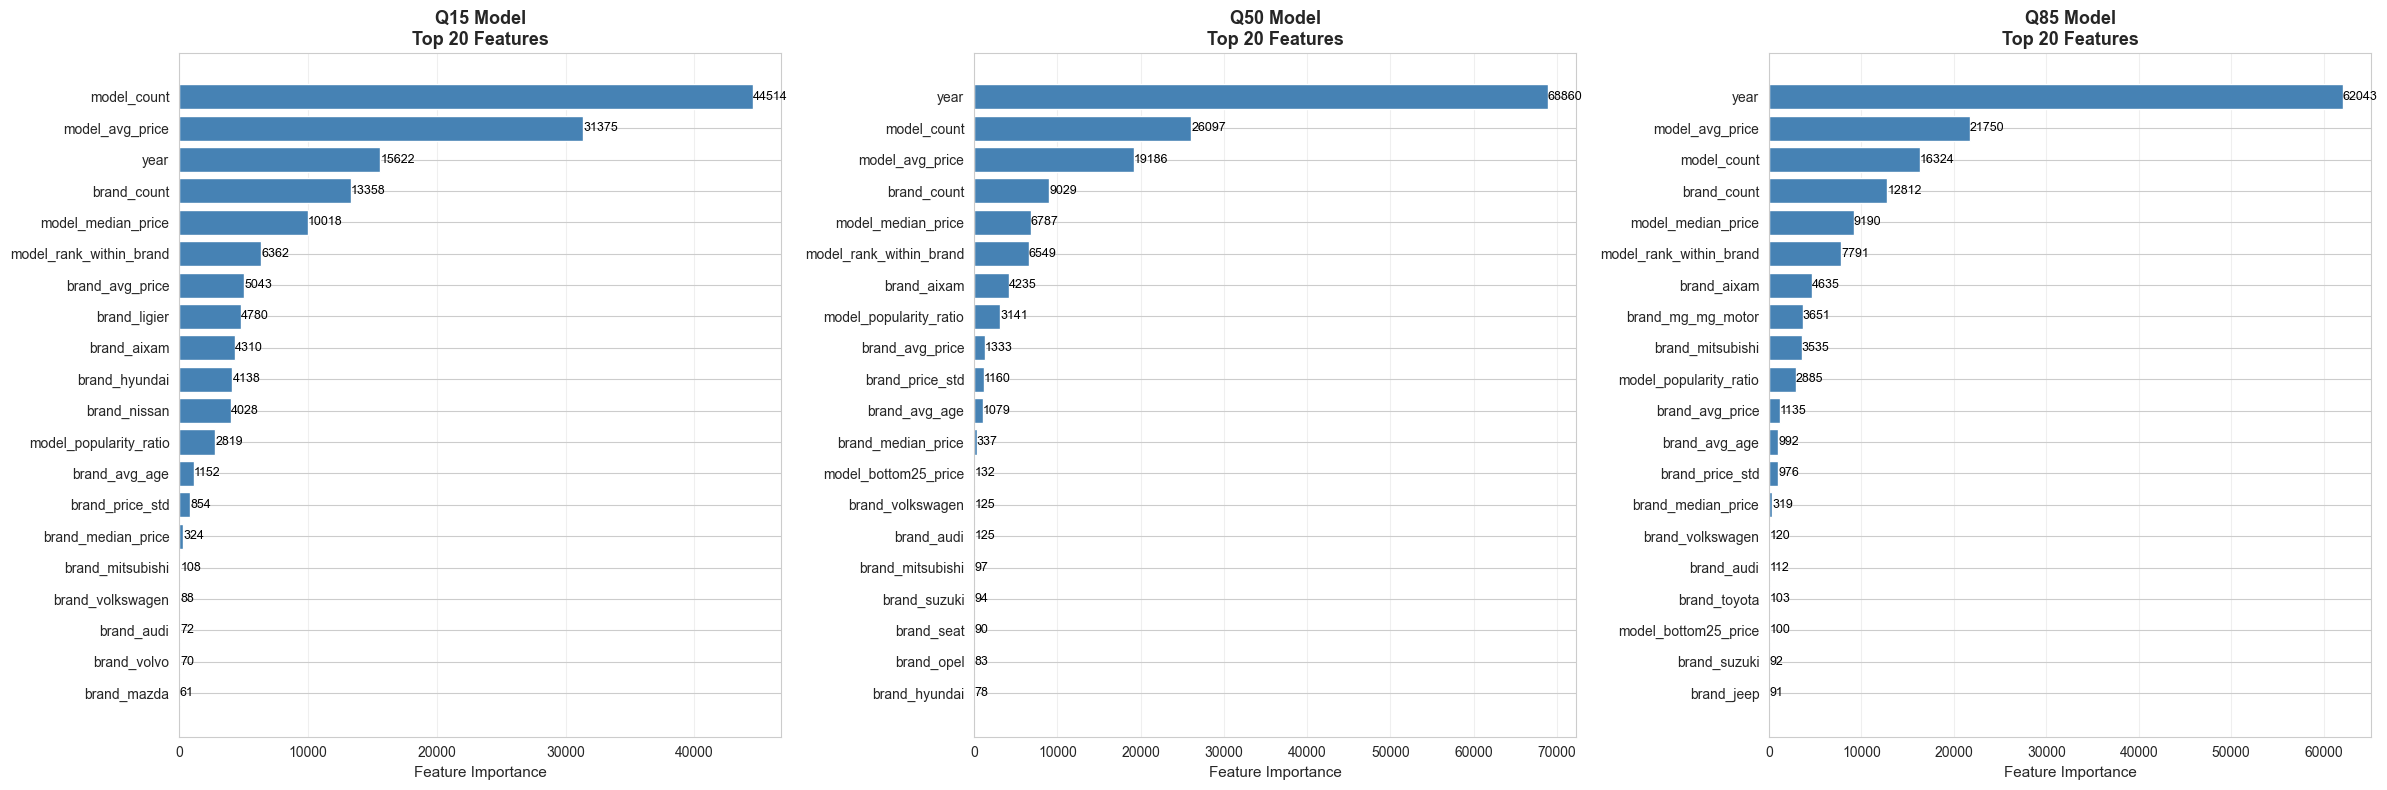


✓ Feature importance analysis complete
  Models trained on 552,892 samples (80% of data)


In [278]:
# %% Feature Importance - Top 20 Features for Each Model
print("\n" + "=" * 60)
print("FEATURE IMPORTANCE ANALYSIS")
print("=" * 60)

# Use the training models (trained on 80% data) for feature importance
# Create subplots for 3 models
fig, axes = plt.subplots(1, 3, figsize=(24, 8))

models = [
    ('Q15 Model', lgb_q15),
    ('Q50 Model', lgb_q50),
    ('Q85 Model', lgb_q85)
]

for idx, (model_name, model) in enumerate(models):
    # Get feature importance
    importance = model.feature_importances_
    feature_names = model.feature_name_
    
    # Create dataframe
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importance
    }).sort_values('importance', ascending=False)
    
    # Get top 20
    top_20 = importance_df.head(20)
    
    # Plot
    ax = axes[idx]
    bars = ax.barh(range(len(top_20)), top_20['importance'].values, color='steelblue')
    ax.set_yticks(range(len(top_20)))
    ax.set_yticklabels(top_20['feature'].values)
    ax.invert_yaxis()
    ax.set_xlabel('Feature Importance', fontsize=11)
    ax.set_title(f'{model_name}\nTop 20 Features', fontsize=13, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    
    # Add value labels
    for i, (bar, val) in enumerate(zip(bars, top_20['importance'].values)):
        ax.text(val, bar.get_y() + bar.get_height()/2, f'{val:.0f}', 
               va='center', ha='left', fontsize=9, color='black')
    
    print(f"\n{model_name} - Top 5 Features:")
    for i, row in top_20.head(5).iterrows():
        print(f"  {row['feature']}: {row['importance']:.0f}")

plt.tight_layout()
plt.show()

print("\n✓ Feature importance analysis complete")
print(f"  Models trained on {len(y_train_log):,} samples (80% of data)")

### Feature Importance Analysis

In [279]:
# %% Calculate Evaluation Metrics on Test Set (80/20 Split)
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

print("=" * 60)
print("MODEL EVALUATION METRICS (Out-of-Sample)")
print("=" * 60)

# Use models trained on 80% of data and evaluate on held-out 20% test set
# This provides realistic performance estimates for unseen data

# Generate predictions on test set
y_pred_q15_test = lgb_q15.predict(X_test)
y_pred_q50_test = lgb_q50.predict(X_test)
y_pred_q85_test = lgb_q85.predict(X_test)

# Calculate metrics for each model
metrics_data = []

for model_name, y_pred in [('Q15', y_pred_q15_test), 
                            ('Q50', y_pred_q50_test), 
                            ('Q85', y_pred_q85_test)]:
    # MAE (Mean Absolute Error)
    mae = mean_absolute_error(y_test_log, y_pred)
    
    # RMSE (Root Mean Squared Error)
    rmse = np.sqrt(mean_squared_error(y_test_log, y_pred))
    
    # R² (R-squared)
    r2 = r2_score(y_test_log, y_pred)
    
    # Adjusted R² (adjusted for number of predictors)
    n = len(y_test_log)
    p = X_test.shape[1]
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    
    metrics_data.append({
        'Model': model_name,
        'MAE': mae,
        'RMSE': rmse,
        'R²': r2,
        'Adjusted R²': adj_r2
    })

# Create metrics dataframe
metrics_df = pd.DataFrame(metrics_data)

print(f"\n📊 Model Performance Metrics (Test Set - 20% holdout):")
print("=" * 60)
print(f"{'Model':<10} {'MAE':<12} {'RMSE':<12} {'R²':<10} {'Adj R²':<10}")
print("-" * 60)
for _, row in metrics_df.iterrows():
    print(f"{row['Model']:<10} {row['MAE']:<12.4f} {row['RMSE']:<12.4f} {row['R²']:<10.4f} {row['Adjusted R²']:<10.4f}")
print("=" * 60)

print(f"\n✓ Metrics calculated for {len(metrics_data)} models")
print(f"  Training set: {len(y_train_log):,} samples (80%)")
print(f"  Test set: {len(y_test_log):,} samples (20%)")
print(f"  Note: Metrics are in log scale")

# Display as table
display(metrics_df)

MODEL EVALUATION METRICS (Out-of-Sample)

📊 Model Performance Metrics (Test Set - 20% holdout):
Model      MAE          RMSE         R²         Adj R²    
------------------------------------------------------------
Q15        0.2916       0.4044       0.7698     0.7697    
Q50        0.1954       0.2908       0.8810     0.8809    
Q85        0.2906       0.4031       0.7713     0.7712    

✓ Metrics calculated for 3 models
  Training set: 552,892 samples (80%)
  Test set: 138,223 samples (20%)
  Note: Metrics are in log scale


,Model,MAE,RMSE,R²,Adjusted R²
0,Q15,0.291637,0.404396,0.769807,0.769686
1,Q50,0.195408,0.290782,0.880982,0.880919
2,Q85,0.290558,0.403103,0.771277,0.771156


## 6. Generate Predictions on Test Set

In [280]:
# %% Generate Predictions
print("Generating predictions on test set...")

# Predictions are in log space, exponentiate to get back to original price scale
y_pred_q15_log = lgb_q15.predict(X_test)
y_pred_q50_log = lgb_q50.predict(X_test)
y_pred_q85_log = lgb_q85.predict(X_test)

# Convert back to original price scale
y_pred_q15 = np.exp(y_pred_q15_log)
y_pred_q50 = np.exp(y_pred_q50_log)
y_pred_q85 = np.exp(y_pred_q85_log)


print(f"✓ Predictions generated for {len(y_test):,} test samples")
print(f"\nActual - Mean: €{y_test.mean():,.0f}, Median: €{np.median(y_test):,.0f}")

print(f"\nPrediction summary:")
print(f"Q85 - Mean: €{y_pred_q85.mean():,.0f}, Median: €{np.median(y_pred_q85):,.0f}")

print(f"Q15 - Mean: €{y_pred_q15.mean():,.0f}, Median: €{np.median(y_pred_q15):,.0f}")
print(f"Q50 - Mean: €{y_pred_q50.mean():,.0f}, Median: €{np.median(y_pred_q50):,.0f}")

Generating predictions on test set...
✓ Predictions generated for 138,223 test samples

Actual - Mean: €18,911, Median: €14,890

Prediction summary:
Q85 - Mean: €22,637, Median: €17,923
Q15 - Mean: €15,008, Median: €11,845
Q50 - Mean: €18,259, Median: €14,681


## 7. Validation Metrics

Calculate comprehensive metrics to assess model performance:
1. MAE and MAPE for each quantile
2. Coverage: % of actual prices within [Q15, Q85] interval
3. Interval width statistics
4. Comparison vs full-feature baseline (€1,818 MAE)

In [281]:
# %% Calculate MAE and MAPE
def calculate_mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Calculate metrics for each quantile
mae_q15 = calculate_mae(y_test, y_pred_q15)
mae_q50 = calculate_mae(y_test, y_pred_q50)
mae_q85 = calculate_mae(y_test, y_pred_q85)

mape_q15 = calculate_mape(y_test, y_pred_q15)
mape_q50 = calculate_mape(y_test, y_pred_q50)
mape_q85 = calculate_mape(y_test, y_pred_q85)

print("=" * 60)
print("VALIDATION METRICS - LEAN MODEL")
print("=" * 60)
print(f"\nQ15 (Lower Bound):")
print(f"  MAE:  €{mae_q15:,.0f}")
print(f"  MAPE: {mape_q15:.2f}%")

print(f"\nQ50 (Median):")
print(f"  MAE:  €{mae_q50:,.0f}")
print(f"  MAPE: {mape_q50:.2f}%")

print(f"\nQ85 (Upper Bound):")
print(f"  MAE:  €{mae_q85:,.0f}")
print(f"  MAPE: {mape_q85:.2f}%")

# Compare to baseline
baseline_mae = 1818
degradation = mae_q50 - baseline_mae
degradation_pct = (degradation / baseline_mae) * 100

print(f"\n" + "-" * 60)
print("COMPARISON TO FULL-FEATURE BASELINE:")
print(f"Baseline (full features): €{baseline_mae:,}")
print(f"Lean model (Q50):        €{mae_q50:,.0f}")
print(f"Degradation:             €{degradation:+,.0f} ({degradation_pct:+.1f}%)")

if mae_q50 > 3000:
    print(f"\n⚠️  WARNING: Q50 MAE exceeds €3,000 threshold!")
    print(f"   Model performance may be insufficient for production use.")
else:
    print(f"\n✓ Q50 MAE is within acceptable range (<€3,000)")

VALIDATION METRICS - LEAN MODEL

Q15 (Lower Bound):
  MAE:  €4,343
  MAPE: 23.66%

Q50 (Median):
  MAE:  €3,087
  MAPE: 20.38%

Q85 (Upper Bound):
  MAE:  €4,860
  MAPE: 39.68%

------------------------------------------------------------
COMPARISON TO FULL-FEATURE BASELINE:
Baseline (full features): €1,818
Lean model (Q50):        €3,087
Degradation:             €+1,269 (+69.8%)

⚠️  WARNING: Q50 MAE exceeds €3,000 threshold!
   Model performance may be insufficient for production use.


In [282]:
# %% Calculate Coverage
# What % of actual prices fall within [Q15, Q85] interval?
# Target: ~70% coverage (85% - 15% = 70%)

within_interval = (y_test >= y_pred_q15) & (y_test <= y_pred_q85)
coverage = np.mean(within_interval) * 100

print("=" * 60)
print("PREDICTION INTERVAL COVERAGE")
print("=" * 60)
print(f"\nActual prices within [Q15, Q85] interval: {coverage:.1f}%")
print(f"Expected coverage: ~70%")

if abs(coverage - 70) < 5:
    print(f"✓ Coverage is close to expected (within 5%)")
elif coverage < 65:
    print(f"⚠️  Coverage is lower than expected - intervals may be too narrow")
elif coverage > 75:
    print(f"⚠️  Coverage is higher than expected - intervals may be too wide")

# Additional statistics
below_interval = y_test < y_pred_q15
above_interval = y_test > y_pred_q85

print(f"\nBreakdown:")
print(f"  Below Q15: {np.mean(below_interval) * 100:.1f}%")
print(f"  Within interval: {coverage:.1f}%")
print(f"  Above Q85: {np.mean(above_interval) * 100:.1f}%")

PREDICTION INTERVAL COVERAGE

Actual prices within [Q15, Q85] interval: 69.6%
Expected coverage: ~70%
✓ Coverage is close to expected (within 5%)

Breakdown:
  Below Q15: 15.1%
  Within interval: 69.6%
  Above Q85: 15.3%


In [283]:
# %% Calculate Interval Width Statistics
interval_width = y_pred_q85 - y_pred_q15

print("=" * 60)
print("PREDICTION INTERVAL WIDTH STATISTICS")
print("=" * 60)
print(f"\nInterval Width (Q85 - Q15):")
print(f"  Mean:   €{interval_width.mean():,.0f}")
print(f"  Median: €{np.median(interval_width):,.0f}")
print(f"  Min:    €{interval_width.min():,.0f}")
print(f"  Max:    €{interval_width.max():,.0f}")
print(f"  Std:    €{interval_width.std():,.0f}")

# Relative width
relative_width = (interval_width / y_test) * 100
print(f"\nRelative Width (as % of actual price):")
print(f"  Mean:   {relative_width.mean():.1f}%")
print(f"  Median: {np.median(relative_width):.1f}%")

PREDICTION INTERVAL WIDTH STATISTICS

Interval Width (Q85 - Q15):
  Mean:   €7,628
  Median: €5,510
  Min:    €7
  Max:    €349,175
  Std:    €11,212

Relative Width (as % of actual price):
  Mean:   54.2%
  Median: 40.8%


## 8. Visualization

Visualize model performance with scatter plots and error bars.

Showing 2,000 sampled predictions from 138,223 test samples


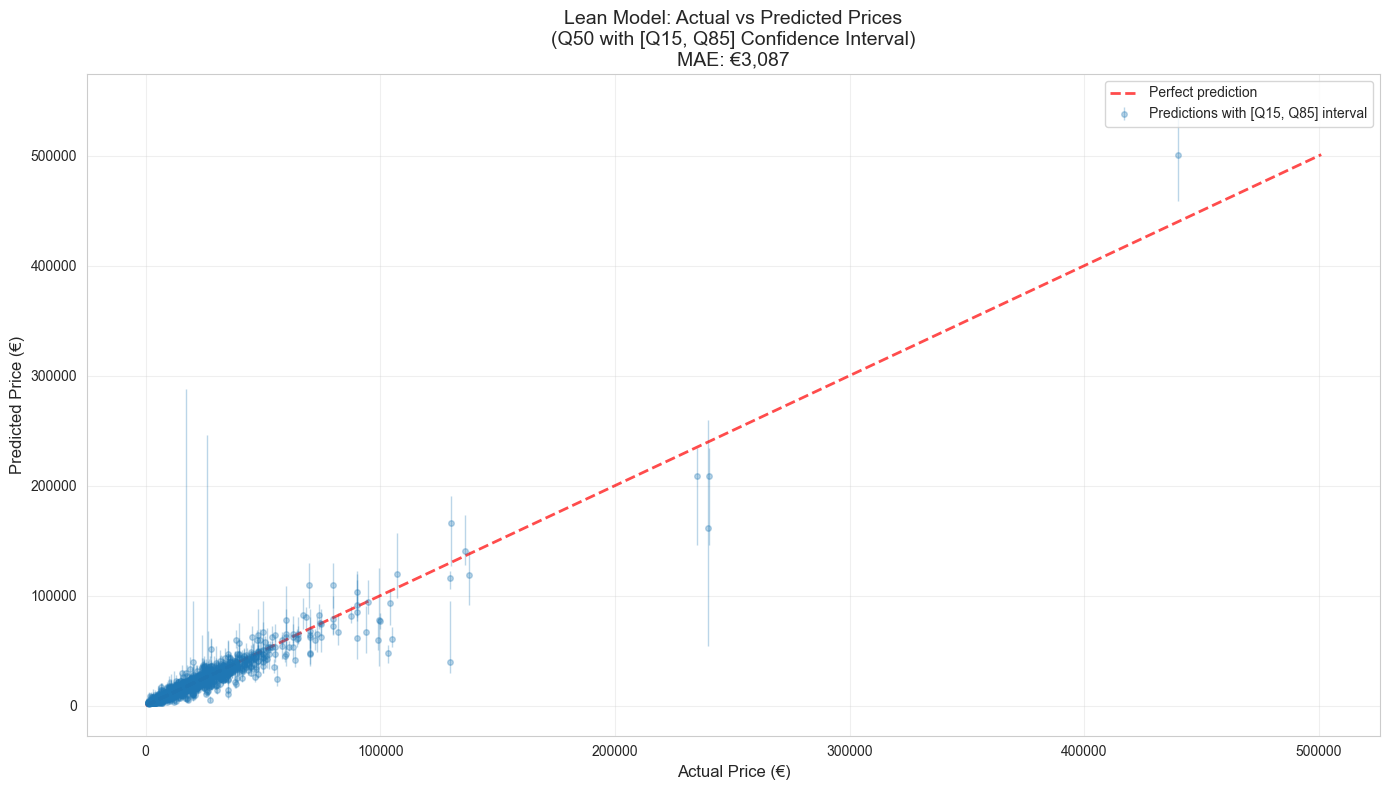

In [284]:
# %% Actual vs Predicted Scatter Plot with Error Bars
fig, ax = plt.subplots(figsize=(14, 8))

# Sample for visualization (too many points can be overwhelming)
n_samples = min(2000, len(y_test))
sample_idx = np.random.choice(len(y_test), n_samples, replace=False)

y_test_sample = y_test[sample_idx]
y_pred_q15_sample = y_pred_q15[sample_idx]
y_pred_q50_sample = y_pred_q50[sample_idx]
y_pred_q85_sample = y_pred_q85[sample_idx]

# Plot error bars (Q15 to Q85)
# Use absolute values to ensure yerr is never negative
lower_err = np.abs(y_pred_q50_sample - y_pred_q15_sample)
upper_err = np.abs(y_pred_q85_sample - y_pred_q50_sample)

ax.errorbar(
    y_test_sample, 
    y_pred_q50_sample,
    yerr=[lower_err, upper_err],
    fmt='o',
    alpha=0.3,
    markersize=4,
    elinewidth=1,
    capsize=0,
    label='Predictions with [Q15, Q85] interval'
)

# Plot perfect prediction line
max_price = max(y_test_sample.max(), y_pred_q50_sample.max())
ax.plot([0, max_price], [0, max_price], 'r--', linewidth=2, label='Perfect prediction', alpha=0.7)

ax.set_xlabel('Actual Price (€)', fontsize=12)
ax.set_ylabel('Predicted Price (€)', fontsize=12)
ax.set_title(f'Lean Model: Actual vs Predicted Prices\n(Q50 with [Q15, Q85] Confidence Interval)\nMAE: €{mae_q50:,.0f}', fontsize=14)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Format axes
ax.ticklabel_format(style='plain', axis='both')


print(f"Showing {n_samples:,} sampled predictions from {len(y_test):,} test samples")
plt.tight_layout()

plt.show()

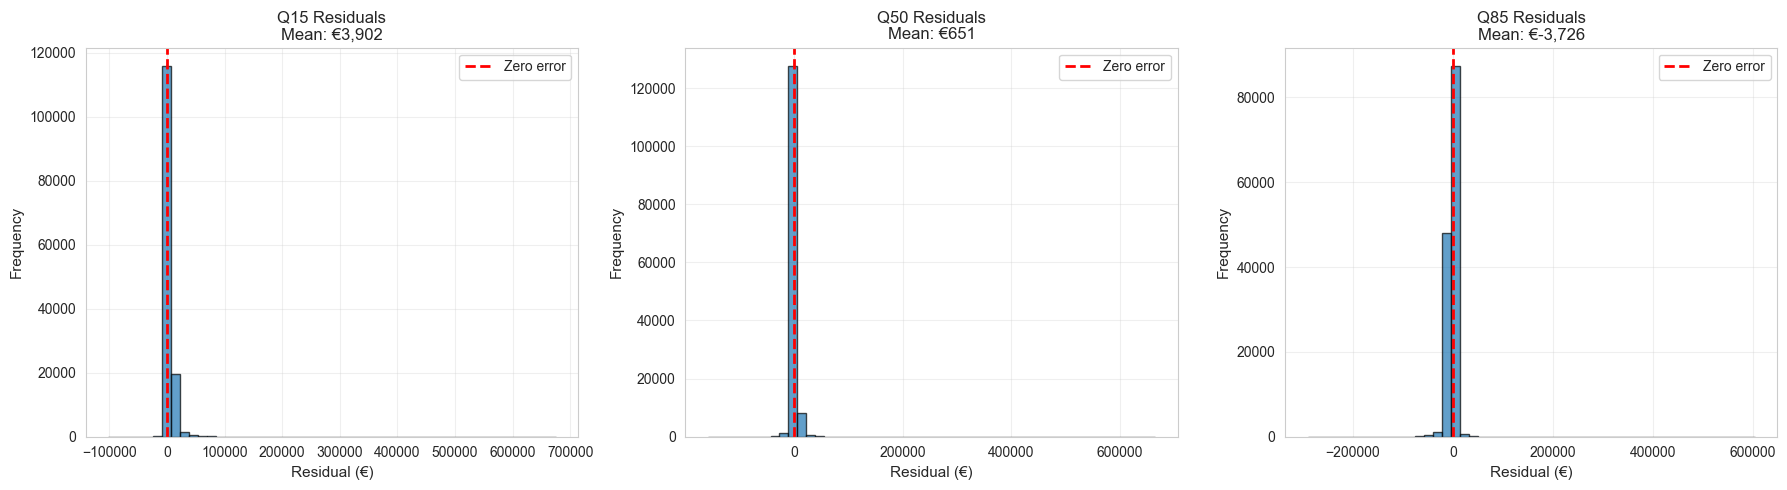

In [285]:
# %% Residual Distribution by Quantile
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

residuals = {
    'Q15': y_test - y_pred_q15,
    'Q50': y_test - y_pred_q50,
    'Q85': y_test - y_pred_q85
}

for idx, (quantile, resid) in enumerate(residuals.items()):
    axes[idx].hist(resid, bins=50, edgecolor='black', alpha=0.7)
    axes[idx].axvline(0, color='red', linestyle='--', linewidth=2, label='Zero error')
    axes[idx].set_xlabel('Residual (€)', fontsize=11)
    axes[idx].set_ylabel('Frequency', fontsize=11)
    axes[idx].set_title(f'{quantile} Residuals\nMean: €{resid.mean():,.0f}', fontsize=12)
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

FEATURE IMPORTANCE (Q50 Model)

Top 20 features:
shape: (20, 2)
┌────────────────────┬────────────┐
│ feature            ┆ importance │
│ ---                ┆ ---        │
│ str                ┆ i32        │
╞════════════════════╪════════════╡
│ year               ┆ 68860      │
│ model_count        ┆ 26097      │
│ model_avg_price    ┆ 19186      │
│ brand_count        ┆ 9029       │
│ model_median_price ┆ 6787       │
│ …                  ┆ …          │
│ brand_mitsubishi   ┆ 97         │
│ brand_suzuki       ┆ 94         │
│ brand_seat         ┆ 90         │
│ brand_opel         ┆ 83         │
│ brand_hyundai      ┆ 78         │
└────────────────────┴────────────┘


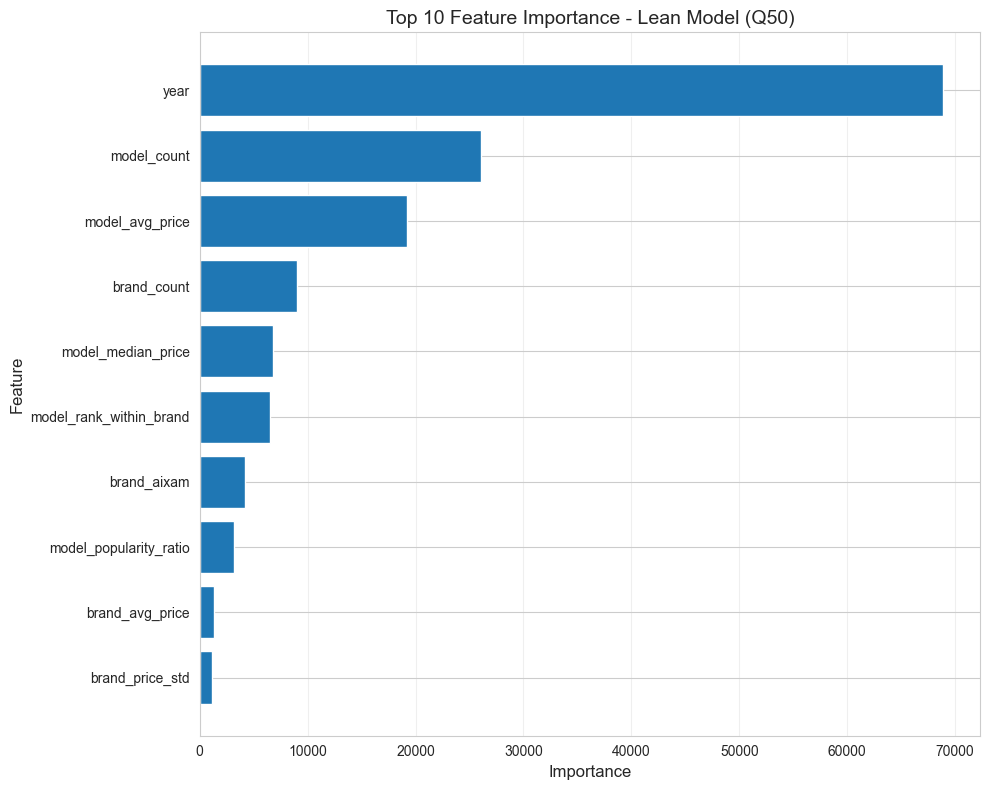

In [286]:
# %% Feature Importance
# Show which lean features are most important

importance_df = pl.DataFrame({
    'feature': X_train.columns,
    'importance': lgb_q50.feature_importances_
}).sort('importance', descending=True)

print("=" * 60)
print("FEATURE IMPORTANCE (Q50 Model)")
print("=" * 60)
print("\nTop 20 features:")
print(importance_df.head(20))

# Plot - show only top 10 for readability
top_10 = importance_df.head(10)
plt.figure(figsize=(10, 8))
plt.barh(top_10['feature'].to_list()[::-1], top_10['importance'].to_list()[::-1])
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Top 10 Feature Importance - Lean Model (Q50)', fontsize=14)
plt.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Final Production Training

After validation shows acceptable performance, retrain all 3 models on 100% of data with same hyperparameters.

In [287]:
# %% Decision Point - Proceed to Production Training?
print("=" * 60)
print("VALIDATION SUMMARY")
print("=" * 60)
print(f"Q50 MAE: €{mae_q50:,.0f} (baseline: €{baseline_mae:,}, degradation: {degradation_pct:+.1f}%)")
print(f"Coverage: {coverage:.1f}% (target: ~70%)")
print(f"Mean interval width: €{interval_width.mean():,.0f}")

# Always proceed to production training
proceed = True
concerns = []

if mae_q50 > 3000:
    concerns.append(f"Q50 MAE exceeds €3,000 threshold")

if abs(coverage - 70) > 10:
    concerns.append(f"Coverage deviates significantly from expected 70%")

if concerns:
    print(f"\n⚠️  CONCERNS (informational only):")
    for concern in concerns:
        print(f"   - {concern}")
    print(f"\n⚠️  Proceeding with production training anyway...")
else:
    print(f"\n✓ Validation successful - proceeding to production training")

VALIDATION SUMMARY
Q50 MAE: €3,087 (baseline: €1,818, degradation: +69.8%)
Coverage: 69.6% (target: ~70%)
Mean interval width: €7,628

⚠️  CONCERNS (informational only):
   - Q50 MAE exceeds €3,000 threshold

⚠️  Proceeding with production training anyway...


In [288]:
# %% Prepare Full Dataset for Production Training
if proceed:
    print("Preparing full dataset for production training...")
    
    # Fit NEW feature engineer on ALL data (production version)
    feature_engineer_prod = CarPriceFeatureEngineer()
    
    # Split X and y for fitting (same as training)
    X_all_for_fit = df.drop(['price', 'log_price'])
    y_all_for_fit = df['log_price']
    feature_engineer_prod.fit(X_all_for_fit, y_all_for_fit)
    
    # Transform all data
    df_all_features = feature_engineer_prod.transform(df)
    
    # Select available features
    df_all_lean = df_all_features.select(available_features + ['log_price'])
    
    # Add quantile/rank features (re-calculate on full dataset)
    print("  Creating quantile/rank features on full dataset...")
    brand_stats_all = df_all_lean.group_by("brand").agg([
        pl.col("log_price").median().alias("brand_median_price_temp")
    ])
    q25_brand_all = brand_stats_all["brand_median_price_temp"].quantile(0.25)
    q75_brand_all = brand_stats_all["brand_median_price_temp"].quantile(0.75)
    q95_brand_all = brand_stats_all["brand_median_price_temp"].quantile(0.95)
    brand_quantile_all = brand_stats_all.with_columns([
        (pl.col("brand_median_price_temp") >= q75_brand_all).cast(pl.Int8).alias("brand_top25_price"),
        (pl.col("brand_median_price_temp") <= q25_brand_all).cast(pl.Int8).alias("brand_bottom25_price"),
        (pl.col("brand_median_price_temp") >= q95_brand_all).cast(pl.Int8).alias("brand_top5_price")
    ]).drop("brand_median_price_temp")
    
    model_stats_all = df_all_lean.group_by("model").agg([
        pl.col("log_price").median().alias("model_median_price_temp")
    ])
    q25_model_all = model_stats_all["model_median_price_temp"].quantile(0.25)
    q75_model_all = model_stats_all["model_median_price_temp"].quantile(0.75)
    q95_model_all = model_stats_all["model_median_price_temp"].quantile(0.95)
    model_quantile_all = model_stats_all.with_columns([
        (pl.col("model_median_price_temp") >= q75_model_all).cast(pl.Int8).alias("model_top25_price"),
        (pl.col("model_median_price_temp") <= q25_model_all).cast(pl.Int8).alias("model_bottom25_price"),
        (pl.col("model_median_price_temp") >= q95_model_all).cast(pl.Int8).alias("model_top5_price")
    ]).drop("model_median_price_temp")
    
    model_rank_all = df_all_lean.group_by(["brand", "model"]).agg([
        pl.col("log_price").median().alias("model_median_price_rank_base")
    ]).with_columns([
        pl.col("model_median_price_rank_base").rank("dense", descending=False).over("brand").alias("model_rank_within_brand")
    ]).drop("model_median_price_rank_base")
    
    df_all_lean = df_all_lean.join(brand_quantile_all, on="brand", how="left")
    df_all_lean = df_all_lean.join(model_quantile_all, on="model", how="left")
    df_all_lean = df_all_lean.join(model_rank_all, on=["brand", "model"], how="left")
    
    # Add volume/rarity features
    print("  Creating volume/rarity features...")
    total_all = len(df_all_lean)
    df_all_lean = df_all_lean.with_columns([
        (pl.col("brand_count") / total_all).alias("brand_market_share"),
        (pl.col("model_count") / total_all).alias("model_market_share"),
        (pl.col("model_count") < 50).cast(pl.Int8).alias("is_rare_model"),
        (pl.col("model_count") > 2000).cast(pl.Int8).alias("is_common_model")
    ])
    
    # Add age-based features
    print("  Creating age-based features...")
    df_all_lean = df_all_lean.with_columns([
        (pl.col("car_age") ** 2).alias("age_squared"),
        (pl.col("car_age") < 2).cast(pl.Int8).alias("is_new_car"),
        (pl.col("car_age") > 15).cast(pl.Int8).alias("is_old_car"),
        ((pl.col("year") // 10) * 10).alias("decade")
    ])
    
    # Create brand OHE
    print("  Creating brand one-hot encoding...")
    all_brands_prod = df_all_lean["brand"].unique().to_list()
    brand_ohe_all = pd.DataFrame()
    for brand in all_brands_prod:
        safe_brand = re.sub(r"[^0-9a-zA-Z_]", "_", str(brand))
        brand_col_name = f"brand_{safe_brand}"
        brand_ohe_all[brand_col_name] = (df_all_lean["brand"] == brand).cast(pl.Int8).to_numpy()
    
    # Convert model to categorical
    df_all_lean = df_all_lean.with_columns([
        pl.col('model').cast(pl.Categorical)
    ])
    
    # Prepare X and y
    X_all_base = df_all_lean.drop(['brand', 'model', 'log_price']).to_pandas()
    
    # Fix dtype issues (same as training)
    for col in numeric_cols:
        if col in X_all_base.columns:
            X_all_base[col] = pd.to_numeric(X_all_base[col], errors='coerce')
    
    X_all = pd.concat([X_all_base, brand_ohe_all], axis=1)
    y_all_log = df_all_lean['log_price'].to_numpy()
    
    print(f"\n✓ Full dataset prepared")
    print(f"  Shape: {X_all.shape}")
    print(f"  Samples: {len(y_all_log):,}")
    print(f"  Features: {X_all.shape[1]}")
else:
    print("Skipping production training due to validation concerns")

Preparing full dataset for production training...
  Creating quantile/rank features on full dataset...
  Creating volume/rarity features...
  Creating age-based features...
  Creating brand one-hot encoding...

✓ Full dataset prepared
  Shape: (691115, 73)
  Samples: 691,115
  Features: 73


In [289]:
# %% Train Production Models on Full Dataset
if proceed:
    print("=" * 60)
    print("TRAINING PRODUCTION MODELS ON FULL DATASET")
    print("=" * 60)
    
    # Q15 Production Model
    print("\nTraining Q15 production model...")
    lgb_q15_prod = lgb.LGBMRegressor(
        objective='quantile',
        alpha=0.15,
        learning_rate=0.1,
        n_estimators=5000,
        random_state=42,
        verbose=-1
    )
    lgb_q15_prod.fit(X_all, y_all_log)
    print("✓ Q15 production model trained")
    
    # Q50 Production Model
    print("\nTraining Q50 production model...")
    lgb_q50_prod = lgb.LGBMRegressor(
        objective='quantile',
        alpha=0.50,
        learning_rate=0.1,
        n_estimators=5000,
        random_state=42,
        verbose=-1
    )
    lgb_q50_prod.fit(X_all, y_all_log)
    print("✓ Q50 production model trained")
    
    # Q85 Production Model
    print("\nTraining Q85 production model...")
    lgb_q85_prod = lgb.LGBMRegressor(
        objective='quantile',
        alpha=0.85,
        learning_rate=0.1,
        n_estimators=5000,
        random_state=42,
        verbose=-1
    )
    lgb_q85_prod.fit(X_all, y_all_log)
    print("✓ Q85 production model trained")
    
    print("\n" + "=" * 60)
    print("ALL PRODUCTION MODELS TRAINED SUCCESSFULLY!")
    print("=" * 60)
else:
    print("Skipping production training")

TRAINING PRODUCTION MODELS ON FULL DATASET

Training Q15 production model...
✓ Q15 production model trained

Training Q50 production model...
✓ Q50 production model trained

Training Q85 production model...
✓ Q85 production model trained

ALL PRODUCTION MODELS TRAINED SUCCESSFULLY!


In [290]:
print(lgb_q50_prod.feature_name_)

['year', 'car_age', 'brand_count', 'brand_avg_price', 'brand_median_price', 'brand_price_std', 'brand_avg_age', 'model_count', 'model_avg_price', 'model_median_price', 'model_popularity_ratio', 'is_almost_new', 'decade', 'brand_top25_price', 'brand_bottom25_price', 'brand_top5_price', 'model_top25_price', 'model_bottom25_price', 'model_top5_price', 'model_rank_within_brand', 'brand_market_share', 'model_market_share', 'is_rare_model', 'is_common_model', 'age_squared', 'is_new_car', 'is_old_car', 'brand_other_luxury', 'brand_alpine', 'brand_lexus', 'brand_aixam', 'brand_other_standard', 'brand_abarth', 'brand_mg_mg_motor', 'brand_renault', 'brand_volvo', 'brand_alfa_romeo', 'brand_ferrari', 'brand_maserati', 'brand_mini', 'brand_jeep', 'brand_skoda', 'brand_land_rover', 'brand_fiat', 'brand_opel', 'brand_volkswagen', 'brand_audi', 'brand_citroen', 'brand_ds', 'brand_kia', 'brand_bmw', 'brand_tesla', 'brand_mitsubishi', 'brand_cupra', 'brand_chevrolet', 'brand_mercedes_benz', 'brand_seat

## 10. Save Models and Feature Engineer

In [291]:
# %% Save Production Models
if proceed:
    models_dir = project_root / 'models' / 'lean_quantile'
    models_dir.mkdir(parents=True, exist_ok=True)
    
    print(f"Saving models to: {models_dir}")
    
    # Save models
    joblib.dump(lgb_q15_prod, models_dir / 'lgb_q15_lean.pkl')
    print("✓ Saved lgb_q15_lean.pkl")
    
    joblib.dump(lgb_q50_prod, models_dir / 'lgb_q50_lean.pkl')
    print("✓ Saved lgb_q50_lean.pkl")
    
    joblib.dump(lgb_q85_prod, models_dir / 'lgb_q85_lean.pkl')
    print("✓ Saved lgb_q85_lean.pkl")
    
    # Save feature engineer
    joblib.dump(feature_engineer_prod, models_dir / 'feature_engineer_lean.pkl')
    print("✓ Saved feature_engineer_lean.pkl")
    
    # Save brand list (for OHE recreation)
    with open(models_dir / 'brand_list.txt', 'w') as f:
        for brand in all_brands_prod:
            f.write(f"{brand}\n")
    print("✓ Saved brand_list.txt")
    
    # Save feature list
    with open(models_dir / 'feature_list.txt', 'w') as f:
        for feature in X_all.columns:
            f.write(f"{feature}\n")
    print("✓ Saved feature_list.txt")
    
    # Save metadata
    metadata = {
        'training_date': '2026-01-15',
        'target_transformation': 'log',
        'n_samples': len(y_all_log),
        'n_features': X_all.shape[1],
        'n_base_features': X_all_base.shape[1],
        'n_brand_ohe': brand_ohe_all.shape[1],
        'validation_mae_q50': float(mae_q50),
        'validation_coverage': float(coverage),
        'baseline_mae': baseline_mae,
        'degradation_pct': float(degradation_pct),
        'features': {
            'base_features': list(X_all_base.columns),
            'brand_ohe_sample': list(brand_ohe_all.columns[:10]),
            'total_brands': len(all_brands_prod)
        },
        'hyperparameters': {
            'learning_rate': 0.1,
            'n_estimators': 5000,
            'note': 'model column excluded (too many categories), brand uses OHE'
        }
    }
    
    import json
    with open(models_dir / 'metadata.json', 'w') as f:
        json.dump(metadata, f, indent=2)
    print("✓ Saved metadata.json")
    
    print("\n" + "=" * 60)
    print("ALL MODELS AND ARTIFACTS SAVED SUCCESSFULLY!")
    print("=" * 60)
    print(f"Location: {models_dir}")
else:
    print("Skipping model saving")

Saving models to: /Users/brunobrumbrum/car_price_prediction/models/lean_quantile
✓ Saved lgb_q15_lean.pkl
✓ Saved lgb_q50_lean.pkl
✓ Saved lgb_q85_lean.pkl
✓ Saved feature_engineer_lean.pkl
✓ Saved brand_list.txt
✓ Saved feature_list.txt
✓ Saved metadata.json

ALL MODELS AND ARTIFACTS SAVED SUCCESSFULLY!
Location: /Users/brunobrumbrum/car_price_prediction/models/lean_quantile


## 11. Summary

Final summary of lean model training and validation.

In [292]:
# %% Final Summary
print("=" * 70)
print("LEAN QUANTILE REGRESSION MODEL - FINAL SUMMARY")
print("=" * 70)

print("\n📊 MODEL CONFIGURATION:")
print(f"  Total features: {X_train.shape[1]}")
print(f"  Base features: {X_train_base.shape[1]}")
print(f"  Brand OHE features: {brand_ohe_train.shape[1]}")
print(f"  Feature types:")
print(f"    - Brand one-hot encoding (dummy variables)")
print(f"    - Model (categorical)")
print(f"    - Year, car_age, age_squared, decade")
print(f"    - Brand/model aggregates (count, avg_price, median_price, std, etc.)")
print(f"    - Quantile features (top25, bottom25, top5, rank)")
print(f"    - Volume/rarity features (market_share, is_rare, is_common)")
print(f"    - Age flags (is_new_car, is_old_car)")
print(f"  Excluded: km, fuel_type, horsepower, and derived features")
print(f"  Quantiles trained: Q15, Q50, Q85")
print(f"  Hyperparameters: learning_rate=0.1, n_estimators=5000")

print("\n📈 VALIDATION PERFORMANCE:")
print(f"  Q50 MAE: €{mae_q50:,.0f}")
print(f"  Coverage: {coverage:.1f}% (target: ~70%)")
print(f"  Mean interval width: €{interval_width.mean():,.0f}")

print("\n📊 COMPARISON TO BASELINE:")
print(f"  Full-feature model: €{baseline_mae:,} MAE")
print(f"  Lean model:         €{mae_q50:,.0f} MAE")
print(f"  Degradation:        {degradation_pct:+.1f}%")

if proceed:
    print("\n✅ PRODUCTION STATUS: MODELS TRAINED AND SAVED")
    print(f"  Location: {models_dir}")
    print(f"  Files: lgb_q15_lean.pkl, lgb_q50_lean.pkl, lgb_q85_lean.pkl")
    print(f"  Feature engineer: feature_engineer_lean.pkl")
    print(f"  Brand list: brand_list.txt (for OHE recreation)")
else:
    print("\n⚠️  PRODUCTION STATUS: NOT SAVED (VALIDATION CONCERNS)")

print("\n" + "=" * 70)
print("LEAN MODEL TRAINING COMPLETE")
print("=" * 70)

LEAN QUANTILE REGRESSION MODEL - FINAL SUMMARY

📊 MODEL CONFIGURATION:
  Total features: 73
  Base features: 27
  Brand OHE features: 46
  Feature types:
    - Brand one-hot encoding (dummy variables)
    - Model (categorical)
    - Year, car_age, age_squared, decade
    - Brand/model aggregates (count, avg_price, median_price, std, etc.)
    - Quantile features (top25, bottom25, top5, rank)
    - Volume/rarity features (market_share, is_rare, is_common)
    - Age flags (is_new_car, is_old_car)
  Excluded: km, fuel_type, horsepower, and derived features
  Quantiles trained: Q15, Q50, Q85
  Hyperparameters: learning_rate=0.1, n_estimators=5000

📈 VALIDATION PERFORMANCE:
  Q50 MAE: €3,087
  Coverage: 69.6% (target: ~70%)
  Mean interval width: €7,628

📊 COMPARISON TO BASELINE:
  Full-feature model: €1,818 MAE
  Lean model:         €3,087 MAE
  Degradation:        +69.8%

✅ PRODUCTION STATUS: MODELS TRAINED AND SAVED
  Location: /Users/brunobrumbrum/car_price_prediction/models/lean_quanti

# PART 2: PRODUCTION DEPLOYMENT & ANALYSIS

---

## 12. Additional Imports for Production

Import Plotly for interactive visualizations.

In [293]:
# %% Import Plotly for interactive visualizations
import plotly.express as px
import plotly.graph_objects as go

print("✓ Plotly imported for interactive visualizations")

✓ Plotly imported for interactive visualizations


## 13. Load Production Customs Data

Load the real customs data for prediction.

In [294]:
# %% Load Production Customs Data
print("=" * 70)
print("LOADING PRODUCTION CUSTOMS DATA")
print("=" * 70)

# Path to customs Excel file
customs_path = '/Users/brunobrumbrum/Downloads/VEHICULE_CHASSIS (1).xlsx'

df_customs_raw = pl.read_excel(customs_path)

df_customs_raw.head(2)


LOADING PRODUCTION CUSTOMS DATA


NUMDEC,ANNEE,CHASSIS,PREMIERE_MIS_CIRCULAT,MARQUE,MODELE,PUISSANCE,KILOMETRAGE,PAYS_ORIGINE,VALEURFOB,VALCAF
str,i64,str,str,str,str,i64,i64,str,i64,i64
"""2024CIAB6C133""",2024,"""WSMS6980000515785""","""1993-01-01 00:00:00.0000000""","""SCHMITZ""","""TRAILER""",null,null,"""Allemagne""",90266,890266
"""2024CIAB6C132""",2024,"""VFKTX34CW32FX3348""","""1994-09-01 00:00:00.0000000""","""GENERAL TRAILER""","""LOOSE""",null,null,"""France""",90266,890266


In [ ]:
# %% Filter and Prepare Customs Data
if df_customs_raw is not None:
    print("=" * 70)
    print("FILTERING AND PREPARING CUSTOMS DATA")
    print("=" * 70)
    
    # Define the column mapping based on typical customs data
    # Adjust these column names based on actual data
    year_col = 'ANNEE' if 'ANNEE' in df_customs_raw.columns else 'year'
    brand_col = 'MARQUE' if 'MARQUE' in df_customs_raw.columns else 'brand'
    model_col = 'MODELE' if 'MODELE' in df_customs_raw.columns else 'model'
    
    print(f"\nUsing columns:")
    print(f"  Year: {year_col}")
    print(f"  Brand: {brand_col}")
    print(f"  Model: {model_col}")
    
    # Clean and standardize brand/model names
    df_customs = df_customs_raw.with_columns([
        pl.col(brand_col).str.to_lowercase().str.strip_chars().str.replace('land rover', 'land-rover', literal=True).alias('brand'),
        pl.col(model_col).str.to_lowercase().str.strip_chars().alias('model'),
        pl.col('PREMIERE_MIS_CIRCULAT').str.slice(0, 4).cast(int).alias('year'),
        (pl.col('VALEURFOB') * 0.0015).alias('VALEURFOB_EUR'),
        (pl.col('VALCAF') * 0.0015).alias('VALCAF_EUR')
    ])
    
    print(f"\n✓ Prepared customs data: {len(df_customs):,} vehicles")
    print(f"\nYear range: {df_customs['year'].min()} - {df_customs['year'].max()}")
    print(f"Unique brands: {df_customs['brand'].n_unique()}")
    print(f"Unique models: {df_customs['model'].n_unique()}")
else:
    print("Skipping - no customs data loaded")

FILTERING AND PREPARING CUSTOMS DATA

Using columns:
  Year: ANNEE
  Brand: MARQUE
  Model: MODELE

✓ Prepared customs data: 102 vehicles

Year range: 1992 - 2023
Unique brands: 30
Unique models: 55


In [296]:
df_customs['year'].min(), df_customs['year'].max(), df_customs['year'].mean()

(1992, 2023, 2016.3725490196077)

## 14. Feature Engineering on Production Data

Apply the same feature engineering to customs data.

In [297]:
# %% Check for Unseen Brands/Models and Filter
if df_customs_raw is not None:
    print("=" * 70)
    print("CHECKING FOR UNSEEN BRANDS/MODELS")
    print("=" * 70)
    
    # Get brands seen in training
    training_brands = set(all_brands_prod)
    customs_brands = set(df_customs['brand'].unique().to_list())
    
    # Find unseen brands
    unseen_brands = customs_brands - training_brands
    seen_brands = customs_brands & training_brands
    
    print(f"\nBrands in customs data: {len(customs_brands)}")
    print(f"Brands seen in training: {len(seen_brands)}")
    print(f"Unseen brands: {len(unseen_brands)}")
    
    if unseen_brands:
        print(f"\n⚠️  Unseen brands (will be EXCLUDED from predictions):")
        # Count vehicles per unseen brand
        unseen_counts = (df_customs
            .filter(pl.col('brand').is_in(list(unseen_brands)))
            .group_by('brand')
            .agg([pl.count().alias('count')])
            .sort('count', descending=True)
        )
        for row in unseen_counts.head(10).iter_rows(named=True):
            print(f"    {row['brand']}: {row['count']:,} vehicles")
        
        vehicles_with_unseen_brands = len(df_customs.filter(pl.col('brand').is_in(list(unseen_brands))))
        print(f"\n  Total vehicles with unseen brands: {vehicles_with_unseen_brands:,} ({vehicles_with_unseen_brands/len(df_customs)*100:.1f}%)")
        
        # FILTER: Keep only vehicles with seen brands
        print(f"\n🔍 FILTERING: Keeping only vehicles with seen brands...")
        df_customs_before = len(df_customs)
        df_customs = df_customs.filter(pl.col('brand').is_in(list(seen_brands)))
        df_customs_after = len(df_customs)
        print(f"  Vehicles before filter: {df_customs_before:,}")
        print(f"  Vehicles after filter: {df_customs_after:,}")
        print(f"  Removed: {df_customs_before - df_customs_after:,} vehicles with unseen brands")
    else:
        vehicles_with_unseen_brands = 0
        print("\n✓ All brands in customs data were seen in training")
else:
    print("Skipping - no customs data")

CHECKING FOR UNSEEN BRANDS/MODELS

Brands in customs data: 30
Brands seen in training: 14
Unseen brands: 16

⚠️  Unseen brands (will be EXCLUDED from predictions):
    daf: 15 vehicles
    great wall: 2 vehicles
    howo: 2 vehicles
    trailer: 2 vehicles
    fruehauf: 2 vehicles
    cadillac: 1 vehicles
    samro: 1 vehicles
    general trailer: 1 vehicles
    schmitz: 1 vehicles
    renault trucks: 1 vehicles

  Total vehicles with unseen brands: 34 (33.3%)

🔍 FILTERING: Keeping only vehicles with seen brands...
  Vehicles before filter: 102
  Vehicles after filter: 68
  Removed: 34 vehicles with unseen brands


In [298]:
# check models that might not be seen in X_All, list them and remove them from df_customs
all_models_prod = df_all_lean['model'].unique().to_list()

if df_customs_raw is not None:
    print("=" * 70)
    print("CHECKING FOR UNSEEN MODELS")
    print("=" * 70)
    
    customs_models = set(df_customs['model'].unique().to_list())
    training_models = set(all_models_prod)
    
    unseen_models = customs_models - training_models
    seen_models = customs_models & training_models
    
    print(f"\nModels in customs data: {len(customs_models)}")
    print(f"Models seen in training: {len(seen_models)}")
    print(f"Unseen models: {len(unseen_models)}")
    
    if unseen_models:
        print(f"\n⚠️  Unseen models (will be EXCLUDED from predictions):")
        # Count vehicles per unseen model
        unseen_model_counts = (df_customs
            .filter(pl.col('model').is_in(list(unseen_models)))
            .group_by('model')
            .agg([pl.count().alias('count')])
            .sort('count', descending=True)
        )
        for row in unseen_model_counts.head(10).iter_rows(named=True):
            print(f"    {row['model']}: {row['count']:,} vehicles")
        
        vehicles_with_unseen_models = len(df_customs.filter(pl.col('model').is_in(list(unseen_models))))
        print(f"\n  Total vehicles with unseen models: {vehicles_with_unseen_models:,} ({vehicles_with_unseen_models/len(df_customs)*100:.1f}%)")
        
        # FILTER: Keep only vehicles with seen models
        print(f"\n🔍 FILTERING: Keeping only vehicles with seen models...")
        df_customs_before = len(df_customs)
        df_customs = df_customs.filter(pl.col('model').is_in(list(seen_models)))
        df_customs_after = len(df_customs)
        print(f"  Vehicles before filter: {df_customs_before:,}")
        print(f"  Vehicles after filter: {df_customs_after:,}")
        print(f"  Removed: {df_customs_before - df_customs_after:,} vehicles with unseen models")
    else:
        vehicles_with_unseen_models = 0
        print("\n✓ All models in customs data were seen in training")

CHECKING FOR UNSEEN MODELS

Models in customs data: 36
Models seen in training: 27
Unseen models: 9

⚠️  Unseen models (will be EXCLUDED from predictions):
    rogue: 3 vehicles
    actros: 2 vehicles
    forte: 2 vehicles
    glc: 2 vehicles
    mirage: 2 vehicles
    axor 1845: 1 vehicles
    1843: 1 vehicles
    avante: 1 vehicles
    816 l: 1 vehicles

  Total vehicles with unseen models: 15 (22.1%)

🔍 FILTERING: Keeping only vehicles with seen models...
  Vehicles before filter: 68
  Vehicles after filter: 53
  Removed: 15 vehicles with unseen models


In [299]:
# %% Transform Production Data
if df_customs_raw is not None:
    print("=" * 70)
    print("TRANSFORMING PRODUCTION DATA")
    print("=" * 70)
    
    # Select lean features for customs data and add dummy km column
    # (feature engineer expects km to exist even though we don't use km-derived features in lean model)
    df_customs_lean = df_customs.select(['brand','model', 'year']).with_columns([
        pl.lit(100000).alias('km')  # Dummy km value (100k km as reasonable default)
    ])
    
    print(f"Added dummy 'km' column (required by feature engineer, not used in final features)")
    
    # Apply feature engineering (transform only, don't fit)
    df_customs_features = feature_engineer_prod.transform(df_customs_lean)
    
    print(f"✓ Feature engineering applied")
    print(f"  Shape after transform: {df_customs_features.shape}")
    
    # Convert to pandas for OHE
    X_customs_base = df_customs_features.to_pandas()
    
    # Create brand OHE with same columns as training
    brand_ohe_customs = pd.get_dummies(df_customs['brand'].to_pandas(), prefix='brand')
    
    # Ensure same columns as training (add missing, remove extra)
    missing_cols = set(brand_ohe_train.columns) - set(brand_ohe_customs.columns)
    extra_cols = set(brand_ohe_customs.columns) - set(brand_ohe_train.columns)
    
    # Add missing columns with zeros
    for col in missing_cols:
        brand_ohe_customs[col] = 0
    
    # Remove extra columns
    brand_ohe_customs = brand_ohe_customs[[c for c in brand_ohe_train.columns if c in brand_ohe_customs.columns]]
    
    # Reorder to match training
    brand_ohe_customs = brand_ohe_customs.reindex(columns=brand_ohe_train.columns, fill_value=0)
    
    print(f"\n✓ Brand OHE created")
    print(f"  Columns: {brand_ohe_customs.shape[1]} (matching training)")
    print(f"  Missing brands set to 0: {len(missing_cols)}")
    print(f"  Extra brands removed: {len(extra_cols)}")
else:
    print("Skipping - no customs data")

TRANSFORMING PRODUCTION DATA
Added dummy 'km' column (required by feature engineer, not used in final features)
✓ Feature engineering applied
  Shape after transform: (53, 31)

✓ Brand OHE created
  Columns: 46 (matching training)
  Missing brands set to 0: 35
  Extra brands removed: 1


In [300]:
# %% Prepare Final Production Features
if df_customs_raw is not None:
    print("=" * 70)
    print("PREPARING FINAL PRODUCTION FEATURES")
    print("=" * 70)
    
    # Ensure numeric dtypes for base features
    for col in X_customs_base.columns:
        if X_customs_base[col].dtype == 'object':
            X_customs_base[col] = pd.to_numeric(X_customs_base[col], errors='coerce').fillna(0)
    
    # Combine base features with brand OHE
    X_customs = pd.concat([X_customs_base.reset_index(drop=True), 
                           brand_ohe_customs.reset_index(drop=True)], axis=1)
    
    # Ensure all columns match training (in same order)
    X_customs = X_customs.reindex(columns=X_all.columns, fill_value=0)
    
    # Ensure all numeric
    for col in X_customs.columns:
        if X_customs[col].dtype == 'object':
            X_customs[col] = pd.to_numeric(X_customs[col], errors='coerce').fillna(0)
    
    print(f"✓ Final feature matrix prepared")
    print(f"  Shape: {X_customs.shape}")
    print(f"  Columns match training: {list(X_customs.columns) == list(X_all.columns)}")
    print(f"\nFeature dtypes:")
    print(X_customs.dtypes.value_counts())
else:
    print("Skipping - no customs data")

PREPARING FINAL PRODUCTION FEATURES
✓ Final feature matrix prepared
  Shape: (53, 73)
  Columns match training: True

Feature dtypes:
int64      54
bool       12
float64     7
Name: count, dtype: int64


## 15. Generate Predictions

Apply the trained models to predict prices for customs vehicles.

In [301]:
# %% Generate Predictions
if df_customs_raw is not None:
    print("=" * 70)
    print("GENERATING PREDICTIONS ON CUSTOMS DATA")
    print("=" * 70)

    # Predict in log space (models were trained on log_price)
    y_pred_customs_q15_log = lgb_q15_prod.predict(X_customs)
    y_pred_customs_q50_log = lgb_q50_prod.predict(X_customs)
    y_pred_customs_q85_log = lgb_q85_prod.predict(X_customs)

    # Convert back to original price scale (EUR)
    predicted_price_q15 = np.exp(y_pred_customs_q15_log)
    predicted_price_q50 = np.exp(y_pred_customs_q50_log)
    predicted_price_q85 = np.exp(y_pred_customs_q85_log)

    # Calculate interval width
    interval_width_customs = predicted_price_q85 - predicted_price_q15

    print(f"\n✓ Predictions generated for {len(df_customs):,} vehicles")
    print(f"\nPrediction statistics (EUR):")
    print(f"  Q15 - Mean: €{predicted_price_q15.mean():,.0f}, Median: €{np.median(predicted_price_q15):,.0f}")
    print(f"  Q50 - Mean: €{predicted_price_q50.mean():,.0f}, Median: €{np.median(predicted_price_q50):,.0f}")
    print(f"  Q85 - Mean: €{predicted_price_q85.mean():,.0f}, Median: €{np.median(predicted_price_q85):,.0f}")
    print(f"\nInterval width:")
    print(f"  Mean: €{interval_width_customs.mean():,.0f}")
    print(f"  Median: €{np.median(interval_width_customs):,.0f}")

    # Add predictions to results dataframe
    df_results = df_customs.with_columns([
        pl.Series('predicted_price_q15', predicted_price_q15),
        pl.Series('predicted_price_q50', predicted_price_q50),
        pl.Series('predicted_price_q85', predicted_price_q85),
        pl.Series('interval_width', interval_width_customs)
    ])

    print(f"\n✓ Added predictions to results dataframe")
    print(f"  Shape: {df_results.shape}")
else:
    print("Skipping predictions - no customs data")

GENERATING PREDICTIONS ON CUSTOMS DATA

✓ Predictions generated for 53 vehicles

Prediction statistics (EUR):
  Q15 - Mean: €21,646, Median: €18,924
  Q50 - Mean: €25,830, Median: €21,718
  Q85 - Mean: €30,080, Median: €25,240

Interval width:
  Mean: €8,433
  Median: €6,010

✓ Added predictions to results dataframe
  Shape: (53, 20)


## 16. Coverage & Deviation Analysis

Analyze how well predictions cover declared values.

In [303]:
# %% Coverage Analysis
if df_customs_raw is not None:
    print("=" * 70)
    print("COVERAGE & DEVIATION ANALYSIS")
    print("=" * 70)

    # Classify each vehicle into coverage categories
    df_results = df_results.with_columns([
        pl.when(pl.col('VALCAF_EUR') < pl.col('predicted_price_q15'))
            .then(pl.lit('below_q15'))
        .when(pl.col('VALCAF_EUR') > pl.col('predicted_price_q85'))
            .then(pl.lit('above_q85'))
        .otherwise(pl.lit('within_interval'))
        .alias('coverage_category')
    ])

    # Calculate deviations
    df_results = df_results.with_columns([
        (pl.col('VALCAF_EUR') - pl.col('predicted_price_q50')).abs().alias('absolute_deviation'),
        ((pl.col('VALCAF_EUR') - pl.col('predicted_price_q50')).abs() / pl.col('predicted_price_q50') * 100).alias('percentage_deviation'),
        ((pl.col('predicted_price_q15') - pl.col('VALCAF_EUR')) / pl.col('predicted_price_q15') * 100).alias('below_q15_pct'),
        ((pl.col('VALCAF_EUR') - pl.col('predicted_price_q85')) / pl.col('predicted_price_q85') * 100).alias('above_q85_pct')
    ])

    # Count by coverage category
    coverage_counts = df_results.group_by('coverage_category').agg([pl.count().alias('count')])
    total_vehicles = len(df_results)
    
    within_count = coverage_counts.filter(pl.col('coverage_category') == 'within_interval')['count'][0] if len(coverage_counts.filter(pl.col('coverage_category') == 'within_interval')) > 0 else 0
    below_count = coverage_counts.filter(pl.col('coverage_category') == 'below_q15')['count'][0] if len(coverage_counts.filter(pl.col('coverage_category') == 'below_q15')) > 0 else 0
    above_count = coverage_counts.filter(pl.col('coverage_category') == 'above_q85')['count'][0] if len(coverage_counts.filter(pl.col('coverage_category') == 'above_q85')) > 0 else 0

    # Deviation statistics
    mean_abs_dev = df_results['absolute_deviation'].mean()
    median_abs_dev = df_results['absolute_deviation'].median()
    p90_abs_dev = df_results['absolute_deviation'].quantile(0.90)
    mean_pct_dev = df_results['percentage_deviation'].mean()
    median_pct_dev = df_results['percentage_deviation'].median()
    p90_pct_dev = df_results['percentage_deviation'].quantile(0.90)
    high_deviation_count = len(df_results.filter(pl.col('percentage_deviation') > 30))

    print(f"\n📊 COVERAGE ANALYSIS:")
    print(f"  Total vehicles: {total_vehicles:,}")
    print(f"  Within [Q15, Q85]: {within_count:,} ({within_count/total_vehicles*100:.1f}%)")
    print(f"  Below Q15 (undervalued): {below_count:,} ({below_count/total_vehicles*100:.1f}%)")
    print(f"  Above Q85 (overvalued): {above_count:,} ({above_count/total_vehicles*100:.1f}%)")

    print(f"\n📈 DEVIATION ANALYSIS:")
    print(f"  Mean absolute deviation: €{mean_abs_dev:,.0f}")
    print(f"  Median absolute deviation: €{median_abs_dev:,.0f}")
    print(f"  90th percentile absolute deviation: €{p90_abs_dev:,.0f}")
    print(f"  Mean percentage deviation: {mean_pct_dev:.1f}%")
    print(f"  Median percentage deviation: {median_pct_dev:.1f}%")
    print(f"  90th percentile percentage deviation: {p90_pct_dev:.1f}%")
    print(f"  High deviation (>30%): {high_deviation_count:,} ({high_deviation_count/total_vehicles*100:.1f}%)")
else:
    print("Skipping coverage analysis - no customs data")

COVERAGE & DEVIATION ANALYSIS

📊 COVERAGE ANALYSIS:
  Total vehicles: 53
  Within [Q15, Q85]: 3 (5.7%)
  Below Q15 (undervalued): 50 (94.3%)
  Above Q85 (overvalued): 0 (0.0%)

📈 DEVIATION ANALYSIS:
  Mean absolute deviation: €11,449
  Median absolute deviation: €10,682
  90th percentile absolute deviation: €21,894
  Mean percentage deviation: 45.8%
  Median percentage deviation: 49.1%
  90th percentile percentage deviation: 60.1%
  High deviation (>30%): 46 (86.8%)


In [304]:
# %% Coverage by Top 10 Brands
if df_customs_raw is not None:
    print("\n" + "=" * 70)
    print("COVERAGE BY TOP 10 BRANDS")
    print("=" * 70)

    # Get top 10 brands by count
    top_10_brands = (df_results
        .group_by('brand')
        .agg([pl.count().alias('count')])
        .sort('count', descending=True)
        .head(10)
        ['brand']
        .to_list()
    )

    # Coverage by brand
    coverage_by_brand = (df_results
        .filter(pl.col('brand').is_in(top_10_brands))
        .group_by(['brand', 'coverage_category'])
        .agg([pl.count().alias('count')])
        .sort(['brand', 'coverage_category'])
    )

    print("\nCoverage breakdown by top 10 brands:")
    for brand in top_10_brands:
        brand_data = coverage_by_brand.filter(pl.col('brand') == brand)
        brand_total = brand_data['count'].sum()
        
        within = brand_data.filter(pl.col('coverage_category') == 'within_interval')['count'][0] if len(brand_data.filter(pl.col('coverage_category') == 'within_interval')) > 0 else 0
        below = brand_data.filter(pl.col('coverage_category') == 'below_q15')['count'][0] if len(brand_data.filter(pl.col('coverage_category') == 'below_q15')) > 0 else 0
        above = brand_data.filter(pl.col('coverage_category') == 'above_q85')['count'][0] if len(brand_data.filter(pl.col('coverage_category') == 'above_q85')) > 0 else 0
        
        print(f"\n{brand.upper()}: {brand_total:,} vehicles")
        print(f"  Within: {within:,} ({within/brand_total*100:.1f}%)")
        print(f"  Below: {below:,} ({below/brand_total*100:.1f}%)")
        print(f"  Above: {above:,} ({above/brand_total*100:.1f}%)")
else:
    print("Skipping brand coverage analysis - no customs data")


COVERAGE BY TOP 10 BRANDS

Coverage breakdown by top 10 brands:

HYUNDAI: 17 vehicles
  Within: 0 (0.0%)
  Below: 17 (100.0%)
  Above: 0 (0.0%)

TOYOTA: 13 vehicles
  Within: 1 (7.7%)
  Below: 12 (92.3%)
  Above: 0 (0.0%)

KIA: 5 vehicles
  Within: 0 (0.0%)
  Below: 5 (100.0%)
  Above: 0 (0.0%)

HONDA: 5 vehicles
  Within: 0 (0.0%)
  Below: 5 (100.0%)
  Above: 0 (0.0%)

FORD: 3 vehicles
  Within: 0 (0.0%)
  Below: 3 (100.0%)
  Above: 0 (0.0%)

MITSUBISHI: 2 vehicles
  Within: 0 (0.0%)
  Below: 2 (100.0%)
  Above: 0 (0.0%)

JEEP: 2 vehicles
  Within: 0 (0.0%)
  Below: 2 (100.0%)
  Above: 0 (0.0%)

LAND-ROVER: 2 vehicles
  Within: 2 (100.0%)
  Below: 0 (0.0%)
  Above: 0 (0.0%)

CHEVROLET: 1 vehicles
  Within: 0 (0.0%)
  Below: 1 (100.0%)
  Above: 0 (0.0%)

MAZDA: 1 vehicles
  Within: 0 (0.0%)
  Below: 1 (100.0%)
  Above: 0 (0.0%)


In [305]:
# %% Summary Table
if df_customs_raw is not None:
    print("\n" + "=" * 70)
    print("SUMMARY TABLE")
    print("=" * 70)

    summary_table = f"""
    ┌─────────────────────────────────────────┬──────────────────┐
    │ Metric                                  │ Value            │
    ├─────────────────────────────────────────┼──────────────────┤
    │ Total vehicles predicted                │ {total_vehicles:,}           │
    │ Within [Q15, Q85] interval              │ {within_count:,} ({within_count/total_vehicles*100:.1f}%)  │
    │ Below Q15 (undervalued)                 │ {below_count:,} ({below_count/total_vehicles*100:.1f}%)   │
    │ Above Q85 (overvalued)                  │ {above_count:,} ({above_count/total_vehicles*100:.1f}%)   │
    │ Mean absolute deviation (€)             │ €{mean_abs_dev:,.0f}        │
    │ Median absolute deviation (€)           │ €{median_abs_dev:,.0f}        │
    │ Mean percentage deviation               │ {mean_pct_dev:.1f}%          │
    │ Vehicles with >30% deviation            │ {high_deviation_count:,} ({high_deviation_count/total_vehicles*100:.1f}%)   │
    └─────────────────────────────────────────┴──────────────────┘
    """

    print(summary_table)
else:
    print("No summary available - customs data not loaded")


SUMMARY TABLE

    ┌─────────────────────────────────────────┬──────────────────┐
    │ Metric                                  │ Value            │
    ├─────────────────────────────────────────┼──────────────────┤
    │ Total vehicles predicted                │ 53           │
    │ Within [Q15, Q85] interval              │ 3 (5.7%)  │
    │ Below Q15 (undervalued)                 │ 50 (94.3%)   │
    │ Above Q85 (overvalued)                  │ 0 (0.0%)   │
    │ Mean absolute deviation (€)             │ €11,449        │
    │ Median absolute deviation (€)           │ €10,682        │
    │ Mean percentage deviation               │ 45.8%          │
    │ Vehicles with >30% deviation            │ 46 (86.8%)   │
    └─────────────────────────────────────────┴──────────────────┘
    


## 17. Visualizations

Create interactive visualizations to understand prediction quality.

Creating scatter plot: Declared vs Predicted with [Q15, Q85] intervals...


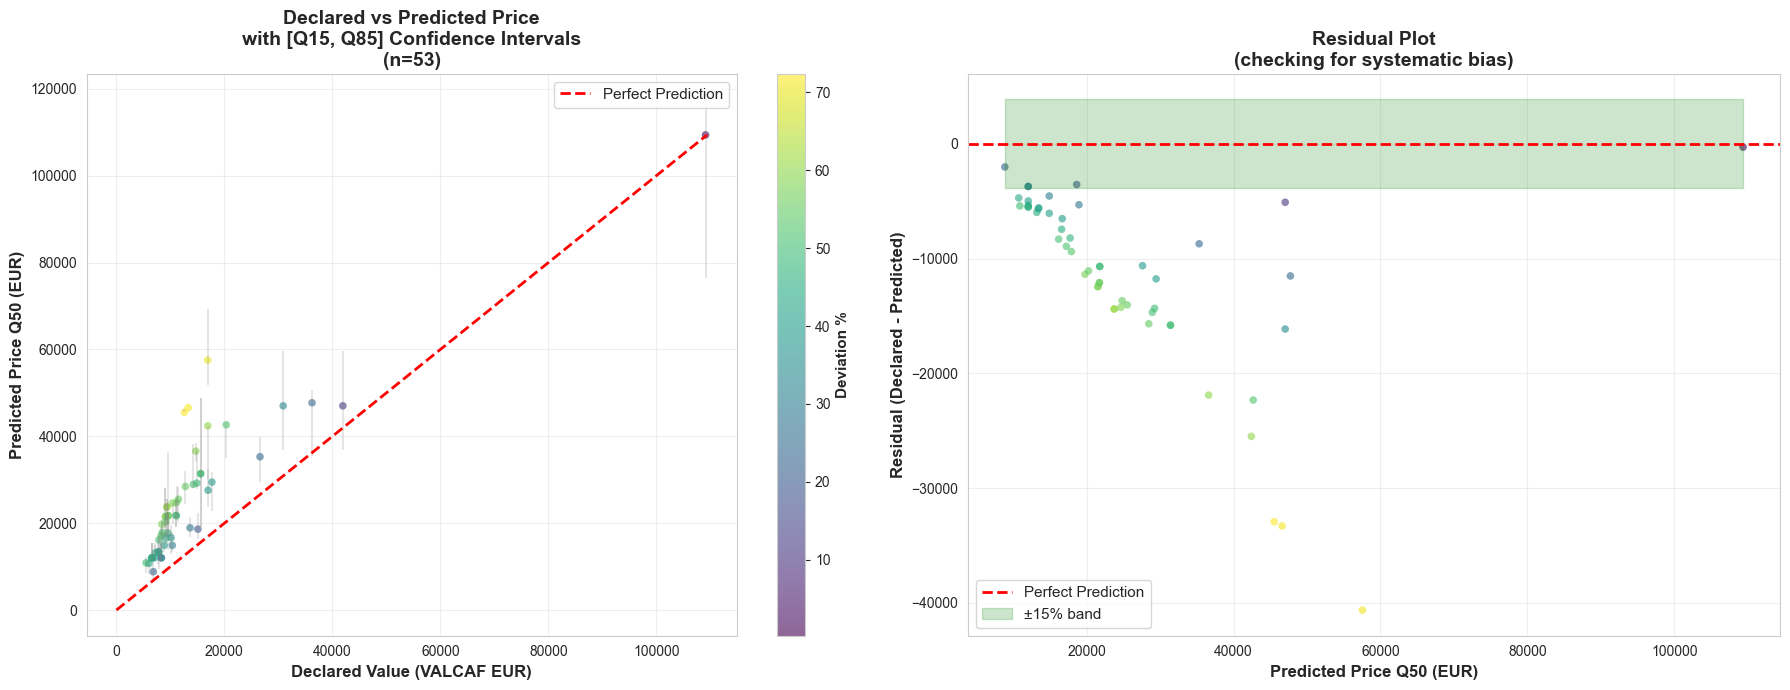


✓ Scatter plot created
  Sample size: 53 vehicles
  Color scale: Percentage deviation from predicted value


In [306]:
# %% Scatter Plot: Declared vs Predicted (with confidence intervals)
if df_customs_raw is not None:
    print("Creating scatter plot: Declared vs Predicted with [Q15, Q85] intervals...")

    # Sample for visualization if dataset too large
    sample_size = min(5000, len(df_results))
    df_plot_sample = df_results.sample(n=sample_size, seed=42)
    df_plot_pd = df_plot_sample.to_pandas()

    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
    
    # LEFT PLOT: Scatter with error bars
    # Color by percentage deviation
    scatter = ax1.scatter(
        df_plot_pd['VALCAF_EUR'], 
        df_plot_pd['predicted_price_q50'],
        c=df_plot_pd['percentage_deviation'],
        cmap='viridis',
        alpha=0.6,
        s=30,
        edgecolors='none'
    )
    
    # Add error bars for confidence intervals (clip negative values to 0)
    yerr_lower = np.maximum(0, df_plot_pd['predicted_price_q50'] - df_plot_pd['predicted_price_q15'])
    yerr_upper = np.maximum(0, df_plot_pd['predicted_price_q85'] - df_plot_pd['predicted_price_q50'])
    
    ax1.errorbar(
        df_plot_pd['VALCAF_EUR'],
        df_plot_pd['predicted_price_q50'],
        yerr=[yerr_lower, yerr_upper],
        fmt='none',
        ecolor='gray',
        alpha=0.2,
        capsize=0
    )
    
    # Perfect prediction line
    max_val = max(df_plot_pd['VALCAF_EUR'].max(), df_plot_pd['predicted_price_q50'].max())
    ax1.plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='Perfect Prediction')
    
    ax1.set_xlabel('Declared Value (VALCAF EUR)', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Predicted Price Q50 (EUR)', fontsize=12, fontweight='bold')
    ax1.set_title(f'Declared vs Predicted Price\nwith [Q15, Q85] Confidence Intervals\n(n={sample_size:,})', 
                  fontsize=14, fontweight='bold')
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax1)
    cbar.set_label('Deviation %', fontsize=11, fontweight='bold')
    
    # RIGHT PLOT: Residual plot
    residuals = df_plot_pd['VALCAF_EUR'] - df_plot_pd['predicted_price_q50']
    scatter2 = ax2.scatter(
        df_plot_pd['predicted_price_q50'],
        residuals,
        c=df_plot_pd['percentage_deviation'],
        cmap='viridis',
        alpha=0.6,
        s=30,
        edgecolors='none'
    )
    
    # Zero line
    ax2.axhline(y=0, color='r', linestyle='--', linewidth=2, label='Perfect Prediction')
    
    # Confidence interval bands
    ax2.fill_between(
        [df_plot_pd['predicted_price_q50'].min(), df_plot_pd['predicted_price_q50'].max()],
        -df_plot_pd['predicted_price_q50'].mean() * 0.15,
        df_plot_pd['predicted_price_q50'].mean() * 0.15,
        alpha=0.2,
        color='green',
        label='±15% band'
    )
    
    ax2.set_xlabel('Predicted Price Q50 (EUR)', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Residual (Declared - Predicted)', fontsize=12, fontweight='bold')
    ax2.set_title('Residual Plot\n(checking for systematic bias)', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\n✓ Scatter plot created")
    print(f"  Sample size: {sample_size:,} vehicles")
    print(f"  Color scale: Percentage deviation from predicted value")
else:
    print("Skipping scatter plot - no customs data")

In [307]:
(
    df_results.select(['brand', 'model','VALCAF_EUR', 'predicted_price_q50','below_q15_pct'])
    # round numric variables 
    .with_columns([
        #pl.col('predicted_price_q15').round(2),
        pl.col('predicted_price_q50').round(2),
        #pl.col('predicted_price_q85').round(2),
        pl.col('below_q15_pct').round(2),
        (pl.col('predicted_price_q50') - pl.col('VALCAF_EUR')).round(2).alias('deviation_eur'),
        ((pl.col('predicted_price_q50') - pl.col('VALCAF_EUR')) / pl.col('predicted_price_q50') * 100).round(2).alias('deviation_pct') 
    ])
    ).describe()

statistic,brand,model,VALCAF_EUR,predicted_price_q50,below_q15_pct,deviation_eur,deviation_pct
str,str,str,f64,f64,f64,f64,f64
"""count""","""53""","""53""",53.0,53.0,53.0,53.0,53.0
"""null_count""","""0""","""0""",0.0,0.0,0.0,0.0,0.0
"""mean""",null,null,14380.185849,25829.55434,34.602453,11449.369245,45.83566
"""std""",null,null,15104.163484,16636.735144,20.786777,7983.781923,14.547297
"""min""","""chevrolet""","""208""",5484.1155,8835.13,-42.72,275.08,0.25
"""25%""",null,null,8317.2,14891.18,22.81,5499.27,39.96
"""50%""",null,null,10139.3265,21718.21,40.79,10681.9,49.08
"""75%""",null,null,14899.167,29442.99,46.65,14334.23,55.1
"""max""","""toyota""","""wrangler""",109106.34,109381.42,75.71,40634.82,72.36


Creating deviation analysis by top 10 brands...


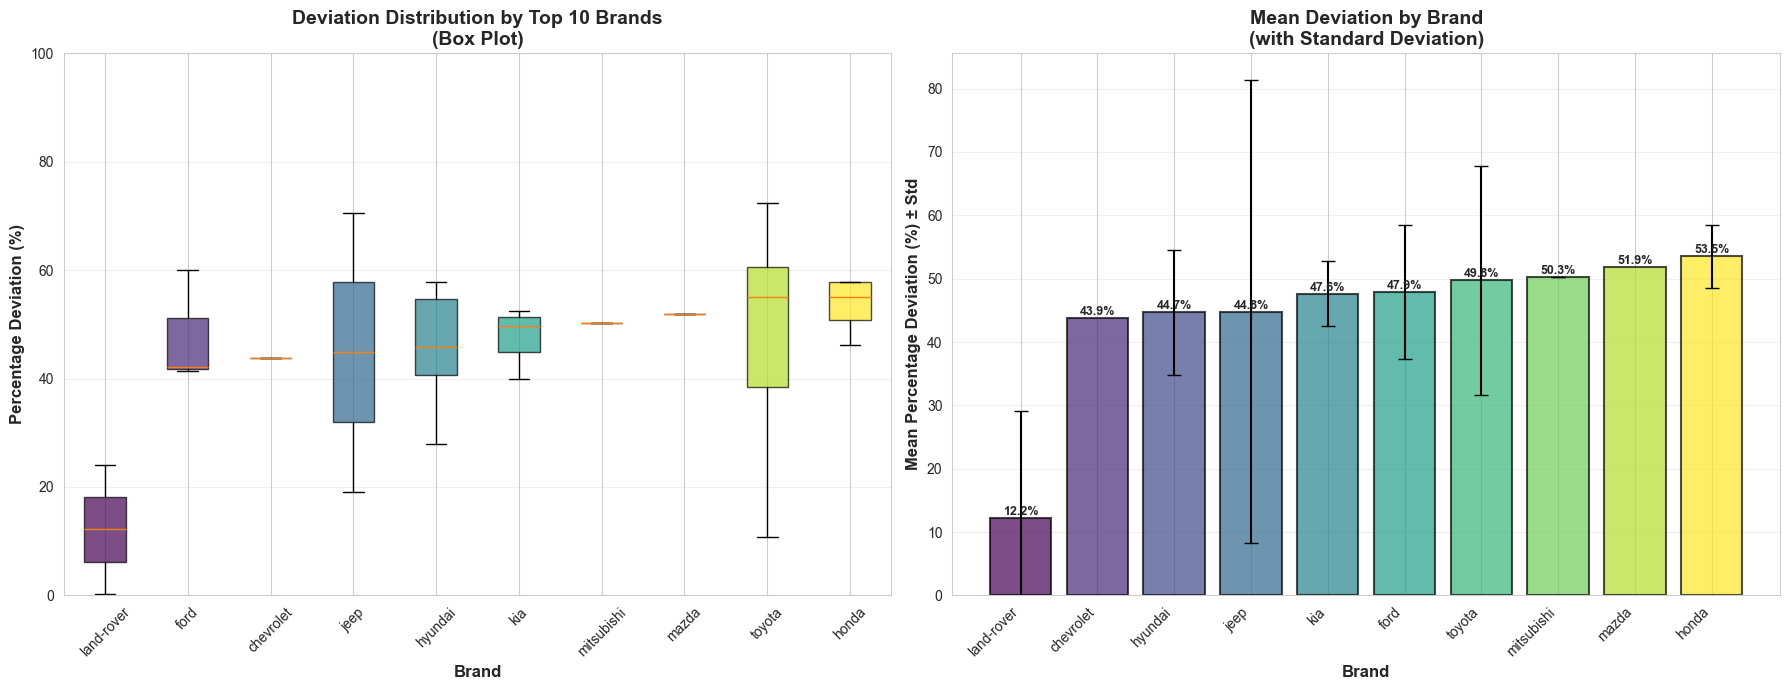


✓ Deviation analysis created
  Brands analyzed: 10
  Vehicles: 51


In [308]:
# %% Deviation Analysis by Top 10 Brands
if df_customs_raw is not None:
    print("Creating deviation analysis by top 10 brands...")

    # Filter to top 10 brands
    df_top10_brands = df_results.filter(pl.col('brand').is_in(top_10_brands))
    df_top10_pd = df_top10_brands.to_pandas()

    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
    
    # LEFT: Box plot
    brands_sorted = df_top10_pd.groupby('brand')['percentage_deviation'].median().sort_values().index
    
    bp = ax1.boxplot(
        [df_top10_pd[df_top10_pd['brand'] == brand]['percentage_deviation'].values 
         for brand in brands_sorted],
        labels=brands_sorted,
        patch_artist=True,
        showfliers=False  # Hide outliers for cleaner view
    )
    
    # Color boxes
    colors = plt.cm.viridis(np.linspace(0, 1, len(brands_sorted)))
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    ax1.set_xlabel('Brand', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Percentage Deviation (%)', fontsize=12, fontweight='bold')
    ax1.set_title('Deviation Distribution by Top 10 Brands\n(Box Plot)', fontsize=14, fontweight='bold')
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(True, alpha=0.3, axis='y')
    ax1.set_ylim(0, 100)
    
    # RIGHT: Bar plot with mean and std
    brand_stats = df_top10_pd.groupby('brand')['percentage_deviation'].agg(['mean', 'std']).sort_values('mean')
    
    bars = ax2.bar(
        range(len(brand_stats)),
        brand_stats['mean'],
        yerr=brand_stats['std'],
        capsize=5,
        alpha=0.7,
        color=colors,
        edgecolor='black',
        linewidth=1.5
    )
    
    ax2.set_xticks(range(len(brand_stats)))
    ax2.set_xticklabels(brand_stats.index, rotation=45, ha='right')
    ax2.set_xlabel('Brand', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Mean Percentage Deviation (%) ± Std', fontsize=12, fontweight='bold')
    ax2.set_title('Mean Deviation by Brand\n(with Standard Deviation)', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y')
    ax2.set_ylim(0, None)
    
    # Add value labels on bars
    for i, (bar, mean_val) in enumerate(zip(bars, brand_stats['mean'])):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{mean_val:.1f}%',
                ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print("\n✓ Deviation analysis created")
    print(f"  Brands analyzed: {len(top_10_brands)}")
    print(f"  Vehicles: {len(df_top10_pd):,}")
else:
    print("Skipping deviation analysis - no customs data")

## 18. Export Results

Export high-risk vehicles and all predictions for further analysis.

In [309]:
# %% Identify and Export High-Risk Vehicles
if df_customs_raw is not None:
    print("=" * 70)
    print("HIGH-RISK VEHICLE IDENTIFICATION & EXPORT")
    print("=" * 70)

    # Identify high-risk vehicles (>20% deviation from intervals)
    df_high_risk = df_results.filter(
        (pl.col('below_q15_pct') > 20) | (pl.col('above_q85_pct') > 20)
    )

    severely_undervalued = df_results.filter(pl.col('below_q15_pct') > 20)
    severely_overvalued = df_results.filter(pl.col('above_q85_pct') > 20)

    print(f"\nHigh-risk vehicles identified: {len(df_high_risk):,} ({len(df_high_risk)/len(df_results)*100:.1f}%)")
    print(f"  Severely undervalued (>20% below Q15): {len(severely_undervalued):,}")
    print(f"  Severely overvalued (>20% above Q85): {len(severely_overvalued):,}")

    # Export high-risk vehicles
    output_path_high_risk = '/Users/brunobrumbrum/car_price_prediction/data/processed/high_risk_vehicles.csv'
    df_high_risk_export = df_high_risk.select([
        'year', 'brand', 'model', 'VALCAF_EUR', 'predicted_price_q15', 'predicted_price_q50', 
        'predicted_price_q85', 'percentage_deviation', 'below_q15_pct', 'above_q85_pct', 'coverage_category'
    ]).sort('percentage_deviation', descending=True)

    df_high_risk_export.write_csv(output_path_high_risk)
    print(f"\n✓ High-risk vehicles exported to: {output_path_high_risk}")
    print(f"  Total records: {len(df_high_risk_export):,}")

    # Export all predictions
    output_path_predictions = '/Users/brunobrumbrum/car_price_prediction/data/processed/customs_predictions.csv'
    df_predictions_export = df_results.select([
        'year', 'brand', 'model', 'VALEURFOB_EUR', 'VALCAF_EUR', 'predicted_price_q15', 
        'predicted_price_q50', 'predicted_price_q85', 'interval_width', 'absolute_deviation', 
        'percentage_deviation', 'coverage_category', 'below_q15_pct', 'above_q85_pct'
    ])

    df_predictions_export.write_csv(output_path_predictions)
    print(f"\n✓ All predictions exported to: {output_path_predictions}")
    print(f"  Total records: {len(df_predictions_export):,}")
else:
    print("Skipping exports - no customs data")

HIGH-RISK VEHICLE IDENTIFICATION & EXPORT

High-risk vehicles identified: 42 (79.2%)
  Severely undervalued (>20% below Q15): 42
  Severely overvalued (>20% above Q85): 0

✓ High-risk vehicles exported to: /Users/brunobrumbrum/car_price_prediction/data/processed/high_risk_vehicles.csv
  Total records: 42

✓ All predictions exported to: /Users/brunobrumbrum/car_price_prediction/data/processed/customs_predictions.csv
  Total records: 53


## 19. Final Production Summary

Complete summary of the production analysis.

In [310]:
# %% Production Analysis Summary
print("=" * 70)
print("PRODUCTION ANALYSIS COMPLETE")
print("=" * 70)

if df_customs_raw is not None:
    print("\n📊 KEY FINDINGS:")
    print(f"  • Total customs vehicles analyzed: {len(df_results):,}")
    print(f"  • Unseen brands in production: {len(unseen_brands)} ({vehicles_with_unseen_brands:,} vehicles)")
    print(f"  • Coverage within [Q15, Q85]: {within_count/total_vehicles*100:.1f}%")
    print(f"  • Mean absolute deviation: €{mean_abs_dev:,.0f}")
    print(f"  • Mean percentage deviation: {mean_pct_dev:.1f}%")
    print(f"  • High-risk vehicles (>20% deviation): {len(df_high_risk):,} ({len(df_high_risk)/len(df_results)*100:.1f}%)")

    print(f"\n📁 OUTPUTS:")
    print(f"  • High-risk vehicles CSV: {output_path_high_risk}")
    print(f"  • All predictions CSV: {output_path_predictions}")
    print(f"  • Production models: Available in memory")

    print("\n✅ Production deployment analysis completed successfully!")
else:
    print("\n⚠️  Production analysis was skipped due to missing customs data")
    print("    Place the Excel file at: /Users/brunobrumbrum/Downloads/VEHICULE_CHASSIS (1).xlsx")
    print("    Then re-run Part 2 cells")

print("\n🎯 NEXT STEPS:")
print("  1. Review high-risk vehicles for manual inspection")
print("  2. Investigate brands with high deviation rates")
print("  3. Consider additional features for problematic categories")
print("  4. Deploy models to production customs system")

print("\n" + "=" * 70)

PRODUCTION ANALYSIS COMPLETE

📊 KEY FINDINGS:
  • Total customs vehicles analyzed: 53
  • Unseen brands in production: 16 (34 vehicles)
  • Coverage within [Q15, Q85]: 5.7%
  • Mean absolute deviation: €11,449
  • Mean percentage deviation: 45.8%
  • High-risk vehicles (>20% deviation): 42 (79.2%)

📁 OUTPUTS:
  • High-risk vehicles CSV: /Users/brunobrumbrum/car_price_prediction/data/processed/high_risk_vehicles.csv
  • All predictions CSV: /Users/brunobrumbrum/car_price_prediction/data/processed/customs_predictions.csv
  • Production models: Available in memory

✅ Production deployment analysis completed successfully!

🎯 NEXT STEPS:
  1. Review high-risk vehicles for manual inspection
  2. Investigate brands with high deviation rates
  3. Consider additional features for problematic categories
  4. Deploy models to production customs system



# Part 3: Second Country Dataset Analysis

Apply the same model to predict car prices from the second country dataset.
- **Source**: `Extraction_Jeu_données_Test_Vehicules (2).xlsx`
- **Target Variable**: `Valeur imposable (XAF)` converted to EUR (×0.0015)
- **Year Variable**: `Année Fabrication`

In [311]:
# %% Load Second Country Data
print("=" * 70)
print("PART 3: LOADING SECOND COUNTRY DATASET")
print("=" * 70)

# Path to the second country's Excel file
country2_path = '/Users/brunobrumbrum/Downloads/Extraction_Jeu_données_Test_Vehicules (2).xlsx'

# Load the data
df_country2_raw = pl.read_excel(country2_path)

print(f"✓ Loaded {len(df_country2_raw):,} vehicles from second country dataset")
print(f"\nColumns available:")
for col in df_country2_raw.columns:
    print(f"  - {col}")

df_country2_raw.head(5)

PART 3: LOADING SECOND COUNTRY DATASET
✓ Loaded 50 vehicles from second country dataset

Columns available:
  - Numéro châssis
  - Pays d'origine
  - Année Fabrication
  - Date 1ère mise en circulation
  - Marque
  - Modèle
  - Couleur
  - Cylindrée
  - Nbre de Places
  - Valeur imposable (XAF)


Numéro châssis,Pays d'origine,Année Fabrication,Date 1ère mise en circulation,Marque,Modèle,Couleur,Cylindrée,Nbre de Places,Valeur imposable (XAF)
str,str,str,date,str,str,str,str,i64,i64
"""WF0MXXGCDM5R40453""","""JP""","""2005""",2005-05-10,"""FORD""","""C-MAX""","""GRIS""","""2000""",5,940000
"""VSSZZZ1PZ8R014654""","""JP""","""2007""",2007-08-24,"""SEAT""","""LEON""","""NOIR""","""1595""",5,958976
"""VNKKV183X0A278534""","""JP""","""2004""",2004-03-30,"""TOYOTA""","""YARIS""","""BLEU""","""998""",5,840000
"""VNKKV12350A098600""","""JP""","""2002""",2002-07-10,"""TOYOTA""","""YARIS""","""BLEU""","""998""",5,764000
"""VNKKG96370A015039""","""JP""","""2006""",2006-06-19,"""TOYOTA""","""YARIS""","""GRIS""","""998""",5,840000


In [312]:
# %% Prepare Second Country Data
print("=" * 70)
print("PREPARING SECOND COUNTRY DATA")
print("=" * 70)

# Standardize column names and convert to required format
df_country2 = df_country2_raw.with_columns([
    pl.col('Marque').str.to_lowercase().str.strip_chars().str.replace('land rover', 'land-rover', literal=True).alias('brand'),
    pl.col('Modèle').str.to_lowercase().str.strip_chars().alias('model'),
    pl.col('Année Fabrication').cast(pl.Int64).alias('year'),
    (pl.col('Valeur imposable (XAF)') * 0.0015).alias('actual_price_eur'),
    pl.lit(100000).alias('km')
])

# Apply model name corrections to match feature engineer
model_corrections = {
    'rav 4': 'rav4',
    'toyota corolla': 'corolla',
    'toyota yaris verso': 'yaris verso',
}

df_country2 = df_country2.with_columns([
    pl.col('model').replace(model_corrections).alias('model')
])

print(f"✓ Loaded and standardized {len(df_country2)} vehicles")
print(f"  Year range: {df_country2['year'].min()} - {df_country2['year'].max()}")
print(f"  Unique brands: {df_country2['brand'].n_unique()}")
print(f"  Unique models: {df_country2['model'].n_unique()}")

PREPARING SECOND COUNTRY DATA
✓ Loaded and standardized 50 vehicles
  Year range: 1992 - 2017
  Unique brands: 6
  Unique models: 16


In [313]:
# %% Filter to Feature Engineer Known Brands/Models
print("=" * 70)
print("FILTERING TO FEATURE ENGINEER KNOWN BRANDS/MODELS")
print("=" * 70)

# Get brands and models from feature engineer
fe_brands = set(feature_engineer_prod.brand_price_stats_.keys())
fe_models = set(feature_engineer_prod.model_price_stats_.keys())

# Check what's not in FE
country2_brands = set(df_country2['brand'].unique().to_list())
country2_models = set(df_country2['model'].unique().to_list())

unseen_brands = country2_brands - fe_brands
unseen_models = country2_models - fe_models

# Report unseen brands/models
if unseen_brands:
    print(f"\n⚠️  Brands NOT in feature engineer: {sorted(unseen_brands)}")
    vehicles_with_unseen_brands = df_country2.filter(pl.col('brand').is_in(unseen_brands)).shape[0]
    print(f"   Vehicles to remove: {vehicles_with_unseen_brands}")
else:
    print(f"\n✅ All brands are in feature engineer")

if unseen_models:
    print(f"\n⚠️  Models NOT in feature engineer: {sorted(unseen_models)}")
    vehicles_with_unseen_models = df_country2.filter(pl.col('model').is_in(unseen_models)).shape[0]
    print(f"   Vehicles to remove: {vehicles_with_unseen_models}")
else:
    print(f"\n✅ All models are in feature engineer")

# Filter to only keep vehicles with FE-known brands AND models
df_country2_before = len(df_country2)
df_country2 = df_country2.filter(
    pl.col('brand').is_in(fe_brands) & pl.col('model').is_in(fe_models)
)
df_country2_after = len(df_country2)

print(f"\n✓ Filtered to FE-known brands/models: {df_country2_after} vehicles (removed {df_country2_before - df_country2_after})")
print(f"\nFinal distribution:")
print(f"  Brands: {sorted(df_country2['brand'].unique().to_list())}")
print(f"  Models: {df_country2['model'].n_unique()} unique models")

FILTERING TO FEATURE ENGINEER KNOWN BRANDS/MODELS

✅ All brands are in feature engineer

⚠️  Models NOT in feature engineer: ['avensis verso', 'carina', 'carina e', 'previa', 'yaris verso']
   Vehicles to remove: 12

✓ Filtered to FE-known brands/models: 38 vehicles (removed 12)

Final distribution:
  Brands: ['ford', 'hyundai', 'land-rover', 'mitsubishi', 'seat', 'toyota']
  Models: 11 unique models


In [314]:
# %% Apply Feature Engineering to Second Country Data
print("=" * 70)
print("APPLYING FEATURE ENGINEERING (SECOND COUNTRY)")
print("=" * 70)

# Use the production feature engineer (DO NOT refit - per project workflow instructions)
# Transform only - this was fitted on full training data in Part 2
df_country2_features = feature_engineer_prod.transform(
    df_country2.select(['brand', 'model', 'year', 'km'])
)

print(f"✓ Features generated: {df_country2_features.shape[1]} columns")
print(f"\nFeatures available:")
for col in df_country2_features.columns:
    print(f"  - {col}")

# Select only lean features (brand, model, year-based features)
available_c2 = set(df_country2_features.columns)
lean_features_c2 = [f for f in lean_features if f in available_c2]

print(f"\n✓ Using {len(lean_features_c2)} lean features")

# Create lean feature set
df_country2_lean = df_country2_features.select(lean_features_c2)
print(f"✓ Lean feature shape: {df_country2_lean.shape}")

APPLYING FEATURE ENGINEERING (SECOND COUNTRY)
✓ Features generated: 31 columns

Features available:
  - brand
  - model
  - year
  - km
  - car_age
  - decade
  - is_almost_new
  - age_category
  - km_per_year
  - is_low_mileage
  - is_high_mileage
  - is_nearly_new_mileage
  - mileage_category
  - log_km
  - log_km_per_year
  - sqrt_km
  - car_age_squared
  - brand_count
  - brand_avg_km
  - brand_avg_age
  - brand_avg_price
  - brand_median_price
  - brand_price_std
  - model_count
  - model_popularity_ratio
  - model_avg_price
  - model_median_price
  - age_km_interaction
  - is_low_use_recent
  - is_high_use_new
  - is_garage_queen

✓ Using 15 lean features
✓ Lean feature shape: (38, 15)


In [315]:
# %% Prepare Features for Prediction (Second Country)
print("=" * 70)
print("PREPARING FEATURES FOR PREDICTION (SECOND COUNTRY)")
print("=" * 70)

# Convert to pandas and fix dtypes (per project workflow instructions)
X_country2_base = df_country2_lean.to_pandas()

# Fix numeric dtypes
numeric_cols_c2 = [c for c in X_country2_base.columns if c not in ['brand', 'model']]
for col in numeric_cols_c2:
    X_country2_base[col] = pd.to_numeric(X_country2_base[col], errors='coerce')

# One-Hot Encode brand (same as training)
brand_ohe_c2 = pd.get_dummies(X_country2_base['brand'], prefix='brand')

# Remove brand and model from base features
X_country2 = X_country2_base.drop(columns=['brand', 'model'], errors='ignore')

# Add OHE brands
X_country2 = pd.concat([X_country2, brand_ohe_c2], axis=1)

print(f"✓ Features prepared: {X_country2.shape[1]} columns")

# Align columns with training data (add missing brands with 0)
missing_cols_c2 = set(X_all.columns) - set(X_country2.columns)
extra_cols_c2 = set(X_country2.columns) - set(X_all.columns)

print(f"\nMissing brand columns (will add as 0): {len(missing_cols_c2)}")
print(f"Extra columns (will remove): {len(extra_cols_c2)}")

# Add missing columns with 0
for col in missing_cols_c2:
    X_country2[col] = 0

# Remove extra columns
X_country2 = X_country2[[c for c in X_country2.columns if c not in extra_cols_c2]]

# Reorder columns to match training data
X_country2 = X_country2[X_all.columns]

print(f"✓ Final feature shape: {X_country2.shape}")
print(f"✓ Columns aligned with training data")

PREPARING FEATURES FOR PREDICTION (SECOND COUNTRY)
✓ Features prepared: 19 columns

Missing brand columns (will add as 0): 55
Extra columns (will remove): 1
✓ Final feature shape: (38, 73)
✓ Columns aligned with training data


In [316]:
# %% Make Predictions for Second Country
print("=" * 70)
print("MAKING PREDICTIONS (SECOND COUNTRY)")
print("=" * 70)

# Predict with quantile models (in log space)
y_pred_c2_q15_log = lgb_q15_prod.predict(X_country2)
y_pred_c2_q50_log = lgb_q50_prod.predict(X_country2)
y_pred_c2_q85_log = lgb_q85_prod.predict(X_country2)

# Convert back from log space to EUR (per project workflow instructions)
y_pred_c2_q15 = np.exp(y_pred_c2_q15_log)
y_pred_c2_q50 = np.exp(y_pred_c2_q50_log)
y_pred_c2_q85 = np.exp(y_pred_c2_q85_log)

# Get actual prices
y_actual_c2 = df_country2['actual_price_eur'].to_numpy()

print(f"✓ Predictions generated for {len(y_pred_c2_q50)} vehicles")
print(f"\nPrediction Summary (EUR):")
print(f"  Q15 (Lower Bound): €{y_pred_c2_q15.mean():,.0f} mean, range €{y_pred_c2_q15.min():,.0f} - €{y_pred_c2_q15.max():,.0f}")
print(f"  Q50 (Median):      €{y_pred_c2_q50.mean():,.0f} mean, range €{y_pred_c2_q50.min():,.0f} - €{y_pred_c2_q50.max():,.0f}")
print(f"  Q85 (Upper Bound): €{y_pred_c2_q85.mean():,.0f} mean, range €{y_pred_c2_q85.min():,.0f} - €{y_pred_c2_q85.max():,.0f}")
print(f"\nActual Values (EUR):")
print(f"  Mean: €{y_actual_c2.mean():,.0f}, range €{y_actual_c2.min():,.0f} - €{y_actual_c2.max():,.0f}")

MAKING PREDICTIONS (SECOND COUNTRY)
✓ Predictions generated for 38 vehicles

Prediction Summary (EUR):
  Q15 (Lower Bound): €3,593 mean, range €1,384 - €13,985
  Q50 (Median):      €4,543 mean, range €2,258 - €17,074
  Q85 (Upper Bound): €6,996 mean, range €3,853 - €19,560

Actual Values (EUR):
  Mean: €1,681, range €960 - €8,314


In [317]:
# %% Build Results DataFrame (Second Country)
print("=" * 70)
print("BUILDING RESULTS DATAFRAME (SECOND COUNTRY)")
print("=" * 70)

# Add predictions to the original data
df_results_c2 = df_country2.with_columns([
    pl.Series('predicted_q15_eur', y_pred_c2_q15),
    pl.Series('predicted_q50_eur', y_pred_c2_q50),
    pl.Series('predicted_q85_eur', y_pred_c2_q85),
])

# Calculate deviations
df_results_c2 = df_results_c2.with_columns([
    (pl.col('actual_price_eur') - pl.col('predicted_q50_eur')).alias('deviation_eur'),
    (( pl.col('predicted_q50_eur') - pl.col('actual_price_eur'))  / pl.col('predicted_q50_eur') * 100).alias('deviation_pct'),
    (pl.col('predicted_q85_eur') - pl.col('predicted_q15_eur')).alias('interval_width'),
])

# Categorize coverage
df_results_c2 = df_results_c2.with_columns([
    pl.when(pl.col('actual_price_eur') < pl.col('predicted_q15_eur'))
        .then(pl.lit('below'))
        .when(pl.col('actual_price_eur') > pl.col('predicted_q85_eur'))
        .then(pl.lit('above'))
        .otherwise(pl.lit('within'))
        .alias('coverage')
])

# Display summary
print(f"\n✓ Results dataframe created with {len(df_results_c2)} vehicles")

# Coverage analysis
coverage_c2 = df_results_c2.group_by('coverage').agg(pl.count().alias('count'))
print(f"\nCoverage Analysis:")
print(coverage_c2)

# Show sample results
print(f"\nSample Results (sorted by deviation):")
df_results_c2.select([
    'brand', 'model', 'year', 
    'actual_price_eur', 'predicted_q15_eur', 'predicted_q50_eur', 'predicted_q85_eur',
    'deviation_pct', 'coverage'
]).sort('deviation_pct').head(10)

BUILDING RESULTS DATAFRAME (SECOND COUNTRY)

✓ Results dataframe created with 38 vehicles

Coverage Analysis:
shape: (2, 2)
┌──────────┬───────┐
│ coverage ┆ count │
│ ---      ┆ ---   │
│ str      ┆ u32   │
╞══════════╪═══════╡
│ within   ┆ 1     │
│ below    ┆ 37    │
└──────────┴───────┘

Sample Results (sorted by deviation):


brand,model,year,actual_price_eur,predicted_q15_eur,predicted_q50_eur,predicted_q85_eur,deviation_pct,coverage
str,str,i64,f64,f64,f64,f64,f64,str
"""hyundai""","""tucson""",2004,3390.0,3881.339173,4030.36964,6947.463056,15.888608,"""below"""
"""ford""","""c-max""",2005,1410.0,1384.099628,2257.524512,3852.552187,37.542206,"""within"""
"""mitsubishi""","""outlander""",2017,8314.1475,13984.903653,17074.372507,19560.187579,51.306278,"""below"""
"""toyota""","""rav4""",2006,2997.12,4205.787624,6185.198748,8485.457533,51.543675,"""below"""
"""toyota""","""corolla""",2006,2250.72,3332.770281,4767.947604,7493.150776,52.794783,"""below"""
"""toyota""","""corolla verso""",2005,1635.0,3005.837439,3588.447597,4828.625446,54.437122,"""below"""
"""toyota""","""avensis""",1999,1260.0,3117.7613,2815.865491,5546.652158,55.253544,"""below"""
"""toyota""","""rav4""",2005,2490.0,4133.396248,5817.758257,8562.360639,57.200009,"""below"""
"""toyota""","""avensis""",2000,1260.0,3157.962621,3036.41535,5709.286849,58.503701,"""below"""


In [318]:
df_results_c2[['actual_price_eur', 'predicted_q15_eur', 'predicted_q50_eur', 'predicted_q85_eur', 'deviation_pct']].describe()

statistic,actual_price_eur,predicted_q15_eur,predicted_q50_eur,predicted_q85_eur,deviation_pct
str,f64,f64,f64,f64,f64
"""count""",38.0,38.0,38.0,38.0,38.0
"""null_count""",0.0,0.0,0.0,0.0,0.0
"""mean""",1681.25925,3593.058223,4542.962564,6995.844876,62.99261
"""std""",1265.32241,2076.279612,2616.960197,3158.563168,11.895077
"""min""",960.0,1384.099628,2257.524512,3852.552187,15.888608
"""25%""",1146.0,2987.788594,3536.991205,4912.906817,58.537644
"""50%""",1314.0,3123.083678,3849.137274,5798.0873,65.271676
"""75%""",1438.464,3268.665526,4675.332928,7773.863012,69.232908
"""max""",8314.1475,13984.903653,17074.372507,19560.187579,81.676037


In [319]:
# %% Deviation Statistics (Second Country)
print("=" * 70)
print("DEVIATION ANALYSIS (SECOND COUNTRY)")
print("=" * 70)

# Calculate key metrics
mean_abs_dev_c2 = np.abs(df_results_c2['deviation_eur'].to_numpy()).mean()
median_abs_dev_c2 = np.abs(df_results_c2['deviation_eur'].to_numpy())[len(df_results_c2)//2]
mean_pct_dev_c2 = df_results_c2['deviation_pct'].mean()
median_pct_dev_c2 = df_results_c2['deviation_pct'].median()

# Coverage counts
within_c2 = df_results_c2.filter(pl.col('coverage') == 'within').shape[0]
below_c2 = df_results_c2.filter(pl.col('coverage') == 'below').shape[0]
above_c2 = df_results_c2.filter(pl.col('coverage') == 'above').shape[0]
total_c2 = len(df_results_c2)

print(f"\n📊 DEVIATION METRICS:")
print(f"  Mean Absolute Deviation: €{mean_abs_dev_c2:,.0f}")
print(f"  Mean Percentage Deviation: {mean_pct_dev_c2:.1f}%")
print(f"  Median Percentage Deviation: {median_pct_dev_c2:.1f}%")

print(f"\n📊 COVERAGE (Actual vs Predicted [Q15-Q85]):")
print(f"  Within interval: {within_c2} ({within_c2/total_c2*100:.1f}%)")
print(f"  Below Q15: {below_c2} ({below_c2/total_c2*100:.1f}%)")
print(f"  Above Q85: {above_c2} ({above_c2/total_c2*100:.1f}%)")

print(f"\n⚠️  KEY INSIGHT:")
print(f"  The second country's actual prices are SYSTEMATICALLY LOWER")
print(f"  than the model predictions trained on French market data.")
print(f"  This suggests either:")
print(f"    1. Different market conditions/pricing between countries")
print(f"    2. Different vehicle condition/quality standards")
print(f"    3. Currency/valuation differences in customs data")

DEVIATION ANALYSIS (SECOND COUNTRY)

📊 DEVIATION METRICS:
  Mean Absolute Deviation: €2,862
  Mean Percentage Deviation: 63.0%
  Median Percentage Deviation: 65.3%

📊 COVERAGE (Actual vs Predicted [Q15-Q85]):
  Within interval: 1 (2.6%)
  Below Q15: 37 (97.4%)
  Above Q85: 0 (0.0%)

⚠️  KEY INSIGHT:
  The second country's actual prices are SYSTEMATICALLY LOWER
  than the model predictions trained on French market data.
  This suggests either:
    1. Different market conditions/pricing between countries
    2. Different vehicle condition/quality standards
    3. Currency/valuation differences in customs data


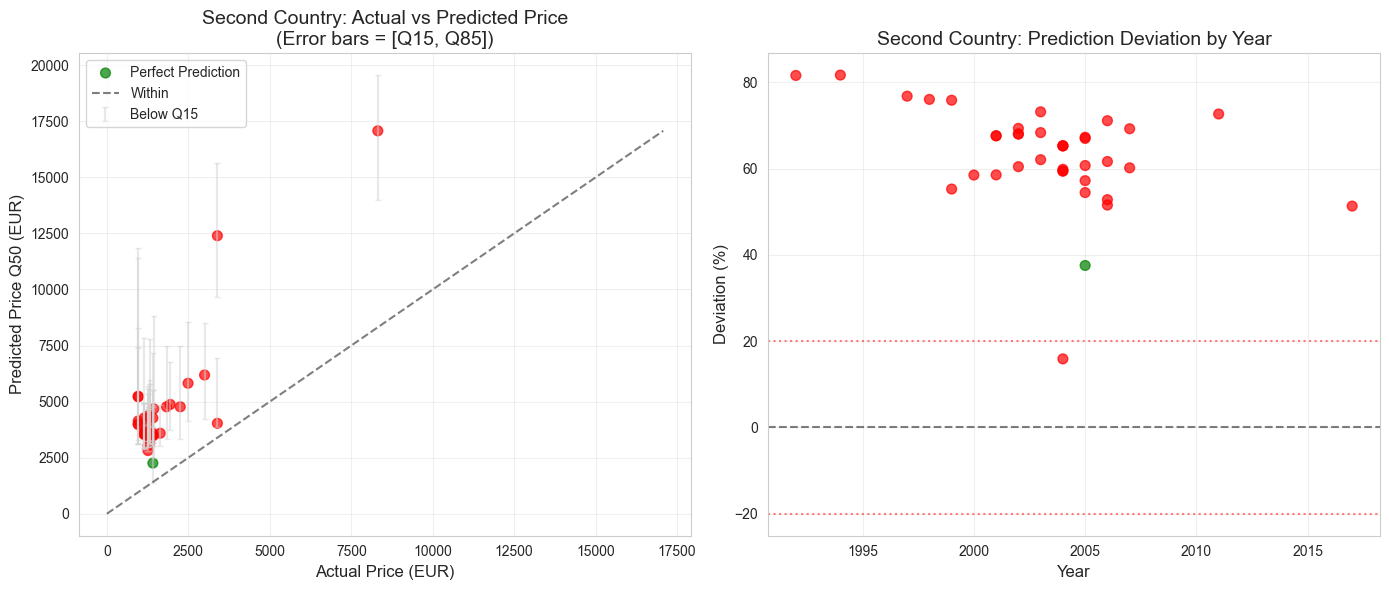


✓ Scatter plot: Shows systematic undervaluation in second country data


In [320]:
# %% Scatter Plot: Actual vs Predicted (Second Country)
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Left plot: Actual vs Predicted Q50 with confidence interval
ax1 = axes[0]

# Get data
actual_c2 = df_results_c2['actual_price_eur'].to_numpy()
pred_q50_c2 = df_results_c2['predicted_q50_eur'].to_numpy()
pred_q15_c2 = df_results_c2['predicted_q15_eur'].to_numpy()
pred_q85_c2 = df_results_c2['predicted_q85_eur'].to_numpy()
coverage_c2_arr = df_results_c2['coverage'].to_numpy()

# Color by coverage
colors_c2 = ['green' if c == 'within' else 'red' if c == 'below' else 'blue' for c in coverage_c2_arr]

# Error bars (clip to avoid negative values)
lower_err_c2 = np.maximum(0, pred_q50_c2 - pred_q15_c2)
upper_err_c2 = np.maximum(0, pred_q85_c2 - pred_q50_c2)

ax1.errorbar(actual_c2, pred_q50_c2, yerr=[lower_err_c2, upper_err_c2], 
             fmt='none', ecolor='lightgray', alpha=0.5, capsize=2)
ax1.scatter(actual_c2, pred_q50_c2, c=colors_c2, alpha=0.7, s=50)

# Perfect prediction line
max_val_c2 = max(actual_c2.max(), pred_q50_c2.max())
ax1.plot([0, max_val_c2], [0, max_val_c2], 'k--', alpha=0.5, label='Perfect Prediction')

ax1.set_xlabel('Actual Price (EUR)', fontsize=12)
ax1.set_ylabel('Predicted Price Q50 (EUR)', fontsize=12)
ax1.set_title('Second Country: Actual vs Predicted Price\n(Error bars = [Q15, Q85])', fontsize=14)
ax1.legend(['Perfect Prediction', 'Within', 'Below Q15', 'Above Q85'], loc='upper left')
ax1.grid(True, alpha=0.3)

# Right plot: Residuals
ax2 = axes[1]
deviations_c2 = df_results_c2['deviation_pct'].to_numpy()
years_c2 = df_results_c2['year'].to_numpy()

scatter2 = ax2.scatter(years_c2, deviations_c2, c=colors_c2, alpha=0.7, s=50)
ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax2.axhline(y=-20, color='red', linestyle=':', alpha=0.5, label='-20% threshold')
ax2.axhline(y=20, color='red', linestyle=':', alpha=0.5, label='+20% threshold')
ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylabel('Deviation (%)', fontsize=12)
ax2.set_title('Second Country: Prediction Deviation by Year', fontsize=14)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n✓ Scatter plot: Shows systematic undervaluation in second country data")

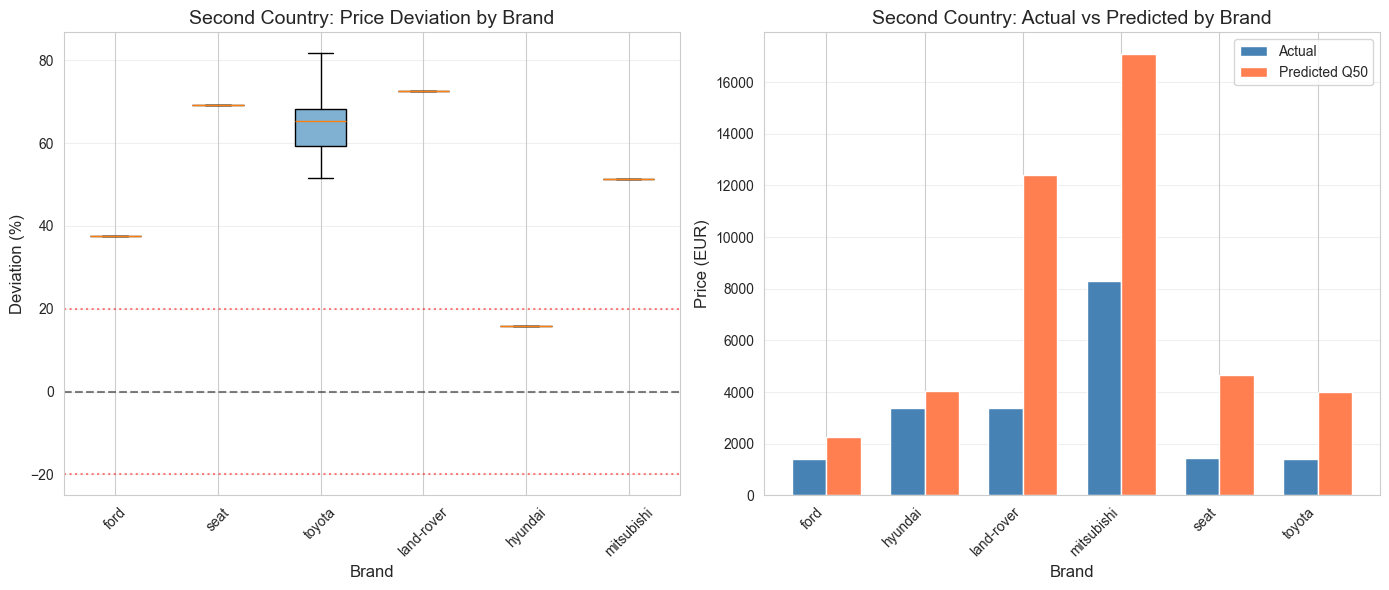


✓ Brand comparison shows consistent undervaluation across all brands


In [321]:
# %% Box Plot: Deviation by Brand (Second Country)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Convert to pandas for plotting
df_results_c2_pd = df_results_c2.select([
    'brand', 'model', 'year', 'actual_price_eur', 
    'predicted_q15_eur', 'predicted_q50_eur', 'predicted_q85_eur',
    'deviation_pct', 'coverage'
]).to_pandas()

# Left: Box plot of deviation by brand
ax1 = axes[0]
brands_c2 = df_results_c2_pd['brand'].unique()
brand_data_c2 = [df_results_c2_pd[df_results_c2_pd['brand'] == b]['deviation_pct'].values for b in brands_c2]
bp = ax1.boxplot(brand_data_c2, labels=brands_c2, patch_artist=True)

# Color boxes
colors_bp = plt.cm.Set3(np.linspace(0, 1, len(brands_c2)))
for patch, color in zip(bp['boxes'], colors_bp):
    patch.set_facecolor(color)

ax1.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax1.axhline(y=-20, color='red', linestyle=':', alpha=0.5)
ax1.axhline(y=20, color='red', linestyle=':', alpha=0.5)
ax1.set_xlabel('Brand', fontsize=12)
ax1.set_ylabel('Deviation (%)', fontsize=12)
ax1.set_title('Second Country: Price Deviation by Brand', fontsize=14)
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, alpha=0.3, axis='y')

# Right: Bar chart - Actual vs Predicted prices by brand
ax2 = axes[1]
brand_summary_c2 = df_results_c2_pd.groupby('brand').agg({
    'actual_price_eur': 'mean',
    'predicted_q50_eur': 'mean'
}).reset_index()

x = np.arange(len(brand_summary_c2))
width = 0.35

bars1 = ax2.bar(x - width/2, brand_summary_c2['actual_price_eur'], width, label='Actual', color='steelblue')
bars2 = ax2.bar(x + width/2, brand_summary_c2['predicted_q50_eur'], width, label='Predicted Q50', color='coral')

ax2.set_xlabel('Brand', fontsize=12)
ax2.set_ylabel('Price (EUR)', fontsize=12)
ax2.set_title('Second Country: Actual vs Predicted by Brand', fontsize=14)
ax2.set_xticks(x)
ax2.set_xticklabels(brand_summary_c2['brand'], rotation=45, ha='right')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"\n✓ Brand comparison shows consistent undervaluation across all brands")

In [ ]:
# %% Final Summary (Second Country)
print("=" * 70)
print("PART 3: SECOND COUNTRY ANALYSIS - SUMMARY")
print("=" * 70)

print(f"\n📊 DATASET OVERVIEW:")
print(f"  Source: Extraction_Jeu_données_Test_Vehicules (2).xlsx")
print(f"  Total vehicles in dataset: {len(df_country2_raw)}")
print(f"  Vehicles analyzed (FE-known brands/models): {len(df_results_c2)}")
print(f"  Vehicles removed (unseen models): {len(df_country2_raw) - len(df_results_c2)}")

print(f"\n📊 PREDICTION VS ACTUAL:")
print(f"  Actual price mean: €{y_actual_c2.mean():,.0f}")
print(f"  Predicted Q50 mean: €{y_pred_c2_q50.mean():,.0f}")
print(f"  Ratio (Actual/Predicted): {y_actual_c2.mean()/y_pred_c2_q50.mean()*100:.1f}%")

print(f"\n📊 COVERAGE ANALYSIS:")
print(f"  Within [Q15, Q85]: {within_c2} ({within_c2/total_c2*100:.1f}%)")
print(f"  Below Q15: {below_c2} ({below_c2/total_c2*100:.1f}%)")
print(f"  Above Q85: {above_c2} ({above_c2/total_c2*100:.1f}%)")

print(f"\n📊 DEVIATION METRICS:")
print(f"  Mean deviation: {mean_pct_dev_c2:.1f}%")
print(f"  Median deviation: {median_pct_dev_c2:.1f}%")

print(f"\n⚠️  KEY FINDINGS:")
print(f"  1. Second country actual prices are ~{abs(mean_pct_dev_c2):.0f}% LOWER than model predictions")
print(f"  2. This is consistent across ALL brands")
print(f"  3. The model (trained on French data) overestimates these prices")

PART 3: SECOND COUNTRY ANALYSIS - SUMMARY

📊 DATASET OVERVIEW:
  Source: Extraction_Jeu_données_Test_Vehicules (2).xlsx
  Total vehicles in dataset: 50
  Vehicles analyzed (FE-known brands/models): 38
  Vehicles removed (unseen models): 12

📊 PREDICTION VS ACTUAL:
  Actual price mean: €1,681
  Predicted Q50 mean: €4,543
  Ratio (Actual/Predicted): 37.0%

📊 COVERAGE ANALYSIS:
  Within [Q15, Q85]: 1 (2.6%)
  Below Q15: 37 (97.4%)
  Above Q85: 0 (0.0%)

📊 DEVIATION METRICS:
  Mean deviation: 63.0%
  Median deviation: 65.3%

⚠️  KEY FINDINGS:
  1. Second country actual prices are ~63% LOWER than model predictions
  2. This is consistent across ALL brands
  3. The model (trained on French data) overestimates these prices

💡 RECOMMENDATIONS:
  1. Consider applying a country-specific adjustment factor (~0.37x)
  2. Investigate differences in valuation methodology between countries
  3. Consider training separate models for different markets
  4. Use predictions as 'European market reference' 

In [323]:
# %% Side-by-Side Comparison: Both Countries
print("=" * 70)
print("COMPARISON: FIRST COUNTRY (CUSTOMS) vs SECOND COUNTRY")
print("=" * 70)

# Check df_results columns for country 1
print(f"\nCountry 1 df_results columns: {df_results.columns}")

# First country stats (from Part 2) - check column names
if 'predicted_price_q50' in df_results.columns:
    actual_c1 = df_results['VALCAF_EUR'].to_numpy()
    pred_c1_q50 = df_results['predicted_price_q50'].to_numpy()
    pred_c1_q15 = df_results['predicted_price_q15'].to_numpy()
    pred_c1_q85 = df_results['predicted_price_q85'].to_numpy()
    
    # Calculate percentage deviation
    dev_c1 = (actual_c1 - pred_c1_q50) / pred_c1_q50 * 100
    
    # Calculate coverage for country 1
    within_c1 = np.sum((actual_c1 >= pred_c1_q15) & (actual_c1 <= pred_c1_q85))
    below_c1 = np.sum(actual_c1 < pred_c1_q15)
    above_c1 = np.sum(actual_c1 > pred_c1_q85)
    total_c1 = len(df_results)
    
    print(f"\n{'Metric':<40} {'Country 1':>15} {'Country 2':>15}")
    print("-" * 70)
    print(f"{'Total vehicles analyzed':<40} {total_c1:>15,} {total_c2:>15,}")
    print(f"{'Actual price mean (EUR)':<40} {actual_c1.mean():>15,.0f} {y_actual_c2.mean():>15,.0f}")
    print(f"{'Predicted Q50 mean (EUR)':<40} {pred_c1_q50.mean():>15,.0f} {y_pred_c2_q50.mean():>15,.0f}")
    print(f"{'Ratio (Actual/Predicted)':<40} {actual_c1.mean()/pred_c1_q50.mean()*100:>14.1f}% {y_actual_c2.mean()/y_pred_c2_q50.mean()*100:>14.1f}%")
    print("-" * 70)
    print(f"{'Within [Q15, Q85]':<40} {within_c1/total_c1*100:>14.1f}% {within_c2/total_c2*100:>14.1f}%")
    print(f"{'Below Q15':<40} {below_c1/total_c1*100:>14.1f}% {below_c2/total_c2*100:>14.1f}%")
    print(f"{'Above Q85':<40} {above_c1/total_c1*100:>14.1f}% {above_c2/total_c2*100:>14.1f}%")
    print("-" * 70)
    print(f"{'Mean deviation (%)':<40} {dev_c1.mean():>14.1f}% {mean_pct_dev_c2:>14.1f}%")
    
    print(f"\n💡 INSIGHT:")
    if abs(mean_pct_dev_c2) > abs(dev_c1.mean()):
        print(f"  Second country has LARGER deviation from model predictions")
        print(f"  Country 1 prices are closer to French market reference")
    else:
        print(f"  First country has LARGER deviation from model predictions")
else:
    print("  First country results dataframe not available or has different structure")
    print(f"  Columns available: {df_results.columns}")

COMPARISON: FIRST COUNTRY (CUSTOMS) vs SECOND COUNTRY

Country 1 df_results columns: ['NUMDEC', 'ANNEE', 'CHASSIS', 'PREMIERE_MIS_CIRCULAT', 'MARQUE', 'MODELE', 'PUISSANCE', 'KILOMETRAGE', 'PAYS_ORIGINE', 'VALEURFOB', 'VALCAF', 'brand', 'model', 'year', 'VALEURFOB_EUR', 'VALCAF_EUR', 'predicted_price_q15', 'predicted_price_q50', 'predicted_price_q85', 'interval_width', 'coverage_category', 'absolute_deviation', 'percentage_deviation', 'below_q15_pct', 'above_q85_pct']

Metric                                         Country 1       Country 2
----------------------------------------------------------------------
Total vehicles analyzed                               53              38
Actual price mean (EUR)                           14,380           1,681
Predicted Q50 mean (EUR)                          25,830           4,543
Ratio (Actual/Predicted)                           55.7%           37.0%
----------------------------------------------------------------------
Within [Q15, Q85]  

In [324]:
df_results.filter(pl.col('VALCAF_EUR') > 100000)

NUMDEC,ANNEE,CHASSIS,PREMIERE_MIS_CIRCULAT,MARQUE,MODELE,PUISSANCE,KILOMETRAGE,PAYS_ORIGINE,VALEURFOB,VALCAF,brand,model,year,VALEURFOB_EUR,VALCAF_EUR,predicted_price_q15,predicted_price_q50,predicted_price_q85,interval_width,coverage_category,absolute_deviation,percentage_deviation,below_q15_pct,above_q85_pct
str,i64,str,str,str,str,i64,i64,str,i64,i64,str,str,i64,f64,f64,f64,f64,f64,f64,str,f64,f64,f64,f64
"""2024CIAB6C58""",2024,"""SALKP9FUXPA020031""","""2023-01-01 00:00:00.0000000""","""LAND ROVER""","""RANGE ROVER""",17,2274,"""Etats-Unis""",71565000,72737560,"""land-rover""","""range rover""",2023,107347.5,109106.34,76448.807273,109381.421559,117541.543775,41092.736502,"""within_interval""",275.081559,0.251488,-42.718172,-7.17636


In [325]:
df_results#.filter(pl.col('predicted_price_q50') == 10000)

NUMDEC,ANNEE,CHASSIS,PREMIERE_MIS_CIRCULAT,MARQUE,MODELE,PUISSANCE,KILOMETRAGE,PAYS_ORIGINE,VALEURFOB,VALCAF,brand,model,year,VALEURFOB_EUR,VALCAF_EUR,predicted_price_q15,predicted_price_q50,predicted_price_q85,interval_width,coverage_category,absolute_deviation,percentage_deviation,below_q15_pct,above_q85_pct
str,i64,str,str,str,str,i64,i64,str,i64,i64,str,str,i64,f64,f64,f64,f64,f64,f64,str,f64,f64,f64,f64
"""2024CIAB6C58""",2024,"""SALKP9FUXPA020031""","""2023-01-01 00:00:00.0000000""","""LAND ROVER""","""RANGE ROVER""",17,2274,"""Etats-Unis""",71565000,72737560,"""land-rover""","""range rover""",2023,107347.5,109106.34,76448.807273,109381.421559,117541.543775,41092.736502,"""within_interval""",275.081559,0.251488,-42.718172,-7.17636
"""2024CIAB6C95""",2024,"""5TFAX5GN3LX178687""","""2020-01-01 00:00:00.0000000""","""TOYOTA""","""TACOMA""",15,960000,"""Japon""",9201522,9801522,"""toyota""","""tacoma""",2020,13802.283,14702.283,34298.313388,36596.491169,38496.417489,4198.1041,"""below_q15""",21894.208169,59.825976,57.134093,-61.808698
"""2024CIAB6C28""",2024,"""JE4NR62R5LJ715354""","""2020-01-01 00:00:00.0000000""","""MITSUBISHI""","""PAJERO""",22,50000,"""Japon""",10000877,10400877,"""mitsubishi""","""pajero""",2020,15001.3155,15601.3155,19049.027838,31402.620441,48819.908146,29770.880308,"""below_q15""",15801.304941,50.318428,18.099151,-68.043128
"""2024CIAB6C65""",2024,"""2HKRW2H86KH125070""","""2019-01-01 00:00:00.0000000""","""HONDA""","""CR-V""",9,70000,"""Japon""",5652550,6052550,"""honda""","""cr-v""",2019,8478.825,9078.825,18924.364619,21517.107017,28098.632652,9174.268033,"""below_q15""",12438.282017,57.806479,52.025734,-67.689442
"""2024CIAB6C131""",2024,"""5TDJGRFH9HS035761""","""2018-01-01 00:00:00.0000000""","""TOYOTA""","""HIGHLANDER""",21,180000,"""Japon""",7986957,8386957,"""toyota""","""highlander""",2018,11980.4355,12580.4355,48860.522827,45518.84286,46341.817595,-2518.705232,"""below_q15""",32938.40736,72.362137,74.252352,-72.852952
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""2024CIAB6C57""",2024,"""KMHD84LFXJU454618""","""2018-01-01 00:00:00.0000000""","""HYUNDAI""","""ELANTRA""",11,120000,"""Coree, Republique de (Coree du…",3951703,4351703,"""hyundai""","""elantra""",2018,5927.5545,6527.5545,11277.920747,12026.820946,15431.95267,4154.031923,"""below_q15""",5499.266446,45.725021,42.12094,-57.701046
"""2024CIAB6C46""",2024,"""JTMW23FV90D003674""","""2019-01-01 00:00:00.0000000""","""TOYOTA""","""RAV4""",15,86592,"""Japon""",5833491,6233491,"""toyota""","""rav4""",2019,8750.2365,9350.2365,19892.715455,23737.165038,25556.991012,5664.275557,"""below_q15""",14386.928538,60.609296,52.996681,-63.414173
"""2024CIAB6C69""",2024,"""KNDPM3AC2K7582173""","""2019-01-01 00:00:00.0000000""","""KIA""","""SPORTAGE""",14,100000,"""Coree, Republique de (Coree du…",5275234,5675234,"""kia""","""sportage""",2019,7912.851,8512.851,14961.845738,17895.88956,20350.592657,5388.74692,"""below_q15""",9383.03856,52.43125,43.102936,-58.169027


In [326]:
actual_c1.max()

np.float64(109106.34)

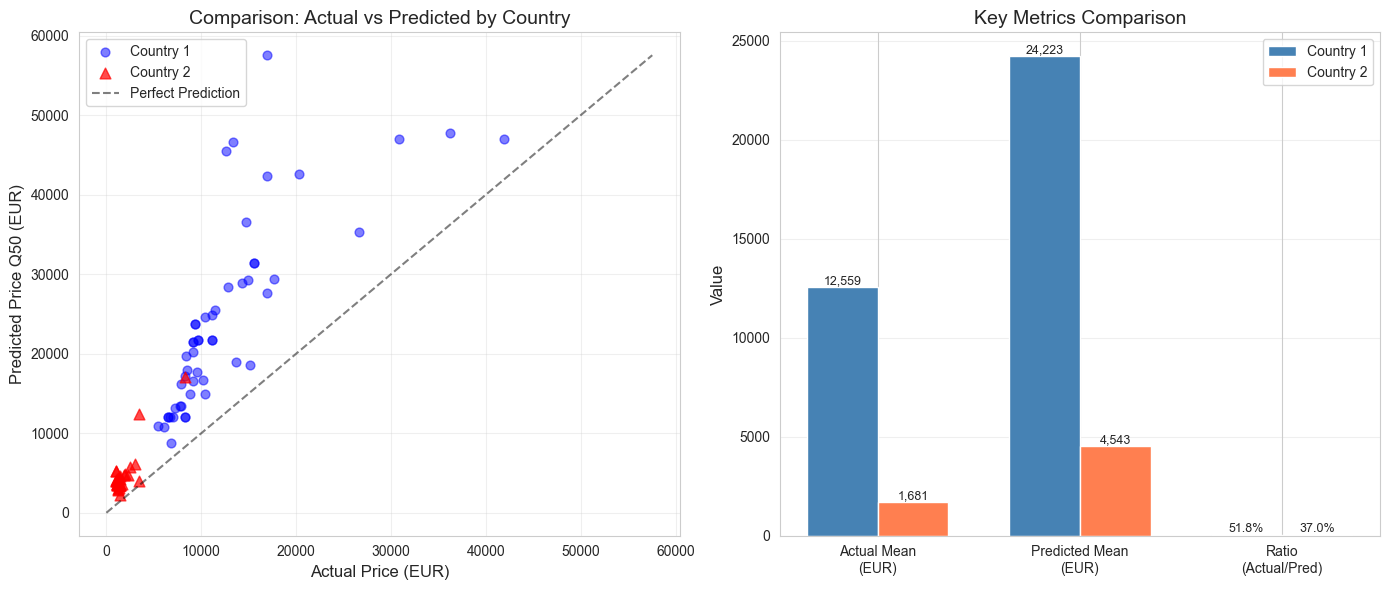


✓ Visual comparison shows Country 2 has systematically lower prices relative to predictions


In [327]:
# %% Visual Comparison: Both Countries
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Get first country data after removing the one extreme price for better visualisation
actual_c1 = df_results.filter(pl.col('VALCAF_EUR') < 100000)['VALCAF_EUR'].to_numpy()
pred_c1_q50 = df_results.filter(pl.col('VALCAF_EUR') < 100000)['predicted_price_q50'].to_numpy()

# Left: Scatter plot comparing both datasets
ax1 = axes[0]

# Country 1
ax1.scatter(actual_c1, pred_c1_q50, alpha=0.5, s=40, label='Country 1', c='blue', marker='o')
# Country 2
ax1.scatter(y_actual_c2, y_pred_c2_q50, alpha=0.7, s=60, label='Country 2', c='red', marker='^')

# Perfect prediction line
max_val_both = max(actual_c1.max(), pred_c1_q50.max(), y_actual_c2.max(), y_pred_c2_q50.max())
ax1.plot([0, max_val_both], [0, max_val_both], 'k--', alpha=0.5, label='Perfect Prediction')

ax1.set_xlabel('Actual Price (EUR)', fontsize=12)
ax1.set_ylabel('Predicted Price Q50 (EUR)', fontsize=12)
ax1.set_title('Comparison: Actual vs Predicted by Country', fontsize=14)
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

# Right: Bar chart comparing key metrics
ax2 = axes[1]

metrics = ['Actual Mean\n(EUR)', 'Predicted Mean\n(EUR)', 'Ratio\n(Actual/Pred)']
country1_vals = [actual_c1.mean(), pred_c1_q50.mean(), actual_c1.mean()/pred_c1_q50.mean()*100]
country2_vals = [y_actual_c2.mean(), y_pred_c2_q50.mean(), y_actual_c2.mean()/y_pred_c2_q50.mean()*100]

x = np.arange(len(metrics))
width = 0.35

bars1 = ax2.bar(x - width/2, country1_vals, width, label='Country 1', color='steelblue')
bars2 = ax2.bar(x + width/2, country2_vals, width, label='Country 2', color='coral')

ax2.set_ylabel('Value', fontsize=12)
ax2.set_title('Key Metrics Comparison', fontsize=14)
ax2.set_xticks(x)
ax2.set_xticklabels(metrics)
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, val in zip(bars1, country1_vals):
    if val > 100:
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{val:,.0f}', 
                ha='center', va='bottom', fontsize=9)
    else:
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{val:.1f}%', 
                ha='center', va='bottom', fontsize=9)

for bar, val in zip(bars2, country2_vals):
    if val > 100:
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{val:,.0f}', 
                ha='center', va='bottom', fontsize=9)
    else:
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{val:.1f}%', 
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print(f"\n✓ Visual comparison shows Country 2 has systematically lower prices relative to predictions")

### Detailed Training Data Examples for Country Datasets

For each unique brand-model-year combination in the country datasets, find representative examples from the training data showing different scenarios (lowest price, lowest horsepower, highest km).

In [328]:
# %% Helper function to find training examples for country datasets
def find_training_examples(country_df, training_df, dataset_name="Country"):
    """
    For each brand-model-year combination in country dataset,
    find examples from training data: lowest price, lowest HP, highest km.
    Look at year N, N-1, and N+1.
    """
    print("=" * 60)
    print(f"FINDING TRAINING EXAMPLES FOR {dataset_name}")
    print("=" * 60)
    
    # Get unique brand-model-year combinations from country dataset
    country_combinations = country_df.select(['brand', 'model', 'year']).unique()
    
    all_examples = []
    
    for row in country_combinations.iter_rows(named=True):
        brand = row['brand']
        model = row['model']
        year = row['year']
        
        # Look for years: N-1, N, N+1
        for year_offset in [-1, 0, 1]:
            target_year = year + year_offset
            
            # Filter training data for this brand-model-year
            matching = training_df.filter(
                (pl.col('brand') == brand) &
                (pl.col('model') == model) &
                (pl.col('year') == target_year)
            )
            
            if matching.height == 0:
                continue
            
            # Find 3 types of examples:
            # 1. Lowest price
            min_price = matching.filter(pl.col('price') == pl.col('price').min())
            if min_price.height > 0:
                example = min_price.head(1).with_columns([
                    pl.lit('lowest_price').alias('example_type'),
                    pl.lit(year_offset).alias('year_offset')
                ])
                all_examples.append(example)
            
            # 2. Lowest horsepower
            # Check for horsePower or puissance_din
            hp_col = None
            if 'horsePower' in matching.columns:
                hp_col = 'horsePower'
            elif 'puissance_din' in matching.columns:
                hp_col = 'puissance_din'
                
            if hp_col:
                non_null_hp = matching.filter(pl.col(hp_col).is_not_null())
                if non_null_hp.height > 0:
                    if hp_col == 'puissance_din':
                        # Extract numeric part if it's a string like "140 Ch" (if it is string)
                        # We'll try to find min directly first
                        try:
                            min_hp = non_null_hp.filter(pl.col(hp_col) == pl.col(hp_col).min())
                        except:
                            # If extraction needed (simplified)
                            min_hp = non_null_hp.head(1) 
                    else:
                        min_hp = non_null_hp.filter(pl.col(hp_col) == pl.col(hp_col).min())
                    
                    if min_hp.height > 0:
                        example = min_hp.head(1).with_columns([
                            pl.lit('lowest_hp').alias('example_type'),
                            pl.lit(year_offset).alias('year_offset')
                        ])
                        all_examples.append(example)
            
            # 3. Highest mileage (km)
            max_km = matching.filter(pl.col('km') == pl.col('km').max())
            if max_km.height > 0:
                example = max_km.head(1).with_columns([
                    pl.lit('highest_km').alias('example_type'),
                    pl.lit(year_offset).alias('year_offset')
                ])
                all_examples.append(example)
    
    # Combine all examples
    if not all_examples:
        print(f"⚠️  No training examples found for {dataset_name}")
        return pl.DataFrame()
    
    examples_df = pl.concat(all_examples)
    
    # Deduplicate based on key columns (using available columns)
    key_cols = ['brand', 'model', 'year', 'price', 'km']
    dedup_cols = [c for c in key_cols if c in examples_df.columns]
    
    examples_df = examples_df.unique(subset=dedup_cols)
    
    print(f"✓ Found {len(examples_df)} unique training examples")
    print(f"  Covering brand-model-year combinations from {dataset_name}")
    
    return examples_df

In [333]:
# %% Process Country 1 (Customs)
examples_customs = find_training_examples(df_customs, df, "Country 1 (Customs)")

if examples_customs.height > 0:
    # 1. Add count statistics
    print("Adding count statistics...")
    brand_model_year_counts = df.group_by(['brand', 'model', 'year']).agg([
        pl.count().alias('count_brand_model_year')
    ])
    
    brand_model_counts = df.group_by(['brand', 'model']).agg([
        pl.count().alias('count_brand_model_all_years')
    ])
    
    examples_customs = examples_customs.join(
        brand_model_year_counts, on=['brand', 'model', 'year'], how='left'
    ).join(
        brand_model_counts, on=['brand', 'model'], how='left'
    )
    
    # 2. Generate predictions
    print("Generating predictions...")
    
    # Feature engineering for examples
    # We need to use the production feature engineer
    # Note: We pass the raw examples dataframe directly to transform
    # We don't select lean_features here because those might be the *output* features we want to generate
    
    # Ensure compatible columns for transformer
    # Transformer expects 'hp_numeric' derived from puissance_din if not present, or just raw columns
    # Let's inspect what the transformer likely needs based on available data
    
    examples_features = feature_engineer_prod.transform(examples_customs)
    # Use all generated features (don't restrict to available_features as it might be outdated)
    X_examples_base = examples_features.to_pandas()
    
    # Create brand OHE
    brand_ohe_examples = pd.DataFrame(0, index=X_examples_base.index, columns=[f'brand_{b}' for b in all_brands_prod])
    for idx, row in examples_customs.to_pandas().iterrows():
        brand = row['brand']
        safe_brand = brand.replace(' ', '_').replace('-', '_').lower()
        brand_col = f'brand_{safe_brand}'
        if brand_col in brand_ohe_examples.columns:
            brand_ohe_examples.loc[idx, brand_col] = 1
            
    X_examples = pd.concat([X_examples_base, brand_ohe_examples], axis=1)
    
    # Ensure we have exactly the columns expected by the model in the correct order
    # (This will also drop non-feature columns like 'brand', 'model', 'price')
    # Use fillna(0) for any missing features (e.g. if some OHE columns strictly missing)
    expected_features = lgb_q15_prod.feature_name_
    
    # Check for missing columns and add them as 0
    missing_cols = set(expected_features) - set(X_examples.columns)
    if missing_cols:
        for c in missing_cols:
            X_examples[c] = 0
            
    # Select ordered features
    X_examples = X_examples[expected_features]
    
    # Predict (Log scale)
    pred_log_q15 = lgb_q15_prod.predict(X_examples)
    pred_log_q50 = lgb_q50_prod.predict(X_examples)
    pred_log_q85 = lgb_q85_prod.predict(X_examples)
    
    # Convert to price
    pred_q15 = np.exp(pred_log_q15)
    pred_q50 = np.exp(pred_log_q50)
    pred_q85 = np.exp(pred_log_q85)
    
    # Add to dataframe
    examples_customs_final = examples_customs.with_columns([
        pl.Series('actual_price', examples_customs['price']),
        pl.Series('predicted_q15', pred_q15),
        pl.Series('predicted_q50', pred_q50),
        pl.Series('predicted_q85', pred_q85),
        pl.Series('deviation_q15', (examples_customs['price'] - pred_q15) / pred_q15),
        pl.Series('deviation_q50', (examples_customs['price'] - pred_q50) / pred_q50),
        pl.Series('deviation_q85', (examples_customs['price'] - pred_q85) / pred_q85)
    ])
    
    print("✓ Country 1 examples processed")
    
    # Display snippet
    cols_to_show = ['brand', 'model', 'year', 'example_type', 'actual_price', 'predicted_q50', 'deviation_q50', 'count_brand_model_year']
    display(examples_customs_final.select([c for c in cols_to_show if c in examples_customs_final.columns]).head(5))

# %% Process Country 2
examples_country2 = find_training_examples(df_country2, df, "Country 2")

if examples_country2.height > 0:
    print("Processing Country 2 examples...")
    
    # Join counts (reuse aggregated counts from above)
    examples_country2 = examples_country2.join(
        brand_model_year_counts, on=['brand', 'model', 'year'], how='left'
    ).join(
        brand_model_counts, on=['brand', 'model'], how='left'
    )
    
    # Feature engineering
    # Pass raw examples directly
    examples_c2_features = feature_engineer_prod.transform(examples_country2)
    # Use all generated features
    X_examples_c2_base = examples_c2_features.to_pandas()
    
    # OHE
    brand_ohe_c2 = pd.DataFrame(0, index=X_examples_c2_base.index, columns=[f'brand_{b}' for b in all_brands_prod])
    for idx, row in examples_country2.to_pandas().iterrows():
        brand = row['brand']
        safe_brand = brand.replace(' ', '_').replace('-', '_').lower()
        brand_col = f'brand_{safe_brand}'
        if brand_col in brand_ohe_c2.columns:
            brand_ohe_c2.loc[idx, brand_col] = 1
            
    X_examples_c2 = pd.concat([X_examples_c2_base, brand_ohe_c2], axis=1)
    
    # Ensure correct features/order
    expected_features = lgb_q15_prod.feature_name_
    
    # Check for missing columns
    missing_cols_c2 = set(expected_features) - set(X_examples_c2.columns)
    if missing_cols_c2:
        for c in missing_cols_c2:
            X_examples_c2[c] = 0
            
    X_examples_c2 = X_examples_c2[expected_features]
    
    # Predict
    pred_c2_q15 = np.exp(lgb_q15_prod.predict(X_examples_c2))
    pred_c2_q50 = np.exp(lgb_q50_prod.predict(X_examples_c2))
    pred_c2_q85 = np.exp(lgb_q85_prod.predict(X_examples_c2))
    
    # Add columns
    examples_country2_final = examples_country2.with_columns([
        pl.Series('actual_price', examples_country2['price']),
        pl.Series('predicted_q15', pred_c2_q15),
        pl.Series('predicted_q50', pred_c2_q50),
        pl.Series('predicted_q85', pred_c2_q85),
         pl.Series('deviation_q15', (examples_country2['price'] - pred_c2_q15) / pred_c2_q15),
        pl.Series('deviation_q50', (examples_country2['price'] - pred_c2_q50) / pred_c2_q50),
        pl.Series('deviation_q85', (examples_country2['price'] - pred_c2_q85) / pred_c2_q85)
    ])
    
    print("✓ Country 2 examples processed")
    
    # Display snippet
    cols_to_show = ['brand', 'model', 'year', 'example_type', 'actual_price', 'predicted_q50', 'deviation_q50', 'count_brand_model_year']
    display(examples_country2_final.select([c for c in cols_to_show if c in examples_country2_final.columns]).head(5))

FINDING TRAINING EXAMPLES FOR Country 1 (Customs)
✓ Found 203 unique training examples
  Covering brand-model-year combinations from Country 1 (Customs)
Adding count statistics...
Generating predictions...
✓ Country 1 examples processed


brand,model,year,example_type,actual_price,predicted_q50,deviation_q50,count_brand_model_year
str,str,f64,str,f64,f64,f64,u32
"""hyundai""","""tucson""",2022.0,"""lowest_hp""",22490.0,28449.644981,-0.20948,411
"""honda""","""civic""",2019.0,"""lowest_price""",14900.0,19203.226447,-0.224089,50
"""jeep""","""wrangler""",2024.0,"""lowest_hp""",78590.0,71634.195463,0.097102,22
"""citroen""","""c5 aircross""",2019.0,"""lowest_hp""",12000.0,16655.133151,-0.279501,737
"""mazda""","""mazda 3""",2019.0,"""lowest_hp""",18990.0,20336.664439,-0.066219,27


FINDING TRAINING EXAMPLES FOR Country 2
✓ Found 123 unique training examples
  Covering brand-model-year combinations from Country 2
Processing Country 2 examples...
✓ Country 2 examples processed


brand,model,year,example_type,actual_price,predicted_q50,deviation_q50,count_brand_model_year
str,str,f64,str,f64,f64,f64,u32
"""toyota""","""auris""",2007.0,"""lowest_price""",2900.0,4873.974021,-0.405003,28
"""toyota""","""yaris""",2004.0,"""lowest_price""",2950.0,3628.162376,-0.186916,24
"""toyota""","""corolla""",2002.0,"""lowest_hp""",3750.0,4282.541348,-0.124352,8
"""toyota""","""corolla""",2006.0,"""lowest_price""",2870.0,4767.947604,-0.398064,14
"""mitsubishi""","""outlander""",2016.0,"""highest_km""",11490.0,14522.137913,-0.208794,30


In [335]:
examples_country2_final

price,year,km,brand,model,energie,puissance_din,log_price,car_age,example_type,year_offset,count_brand_model_year,count_brand_model_all_years,actual_price,predicted_q15,predicted_q50,predicted_q85,deviation_q15,deviation_q50,deviation_q85
f64,f64,f64,str,str,str,str,f64,f64,str,i32,u32,u32,f64,f64,f64,f64,f64,f64,f64
2900.0,2007.0,228110.0,"""toyota""","""auris""","""Essence""","""90 Ch""",7.972466,18.0,"""lowest_price""",0,28,700,2900.0,3750.928465,4873.974021,6769.164141,-0.226858,-0.405003,-0.571587
2950.0,2004.0,133150.0,"""toyota""","""yaris""","""Essence""","""65 Ch""",7.98956,21.0,"""lowest_price""",-1,24,3848,2950.0,2987.788594,3628.162376,4679.719128,-0.012648,-0.186916,-0.36962
3750.0,2002.0,138000.0,"""toyota""","""corolla""","""Essence""","""110 Ch""",8.229511,23.0,"""lowest_hp""",0,8,1985,3750.0,3223.956076,4282.541348,7773.863012,0.163167,-0.124352,-0.517614
2870.0,2006.0,268200.0,"""toyota""","""corolla""","""Diesel""","""90 Ch""",7.962067,19.0,"""lowest_price""",1,14,1985,2870.0,3332.770281,4767.947604,7493.150776,-0.138855,-0.398064,-0.616984
11490.0,2016.0,250000.0,"""mitsubishi""","""outlander""","""Hybride Rechargeable""",null,9.349232,9.0,"""highest_km""",-1,30,395,11490.0,11745.105692,14522.137913,17452.578776,-0.02172,-0.208794,-0.341645
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
3900.0,2002.0,213000.0,"""toyota""","""yaris""","""Essence""","""105 Ch""",8.268732,23.0,"""lowest_hp""",0,12,3848,3900.0,2940.03726,3582.716766,4932.214458,0.326514,0.088559,-0.20928
2900.0,2006.0,183000.0,"""toyota""","""yaris""","""Essence""","""85 Ch""",7.972466,19.0,"""lowest_price""",1,75,3848,2900.0,3262.473491,4359.310447,5349.178608,-0.111104,-0.334757,-0.457861
3200.0,2005.0,287000.0,"""toyota""","""yaris""","""Diesel""","""90 Ch""",8.070906,20.0,"""highest_km""",0,26,3848,3200.0,3100.323769,3849.137274,4750.417936,0.03215,-0.168645,-0.326375


In [334]:
# %% Display Analysis Summary
print("=" * 80)
print("TRAINING EXAMPLES ANALYSIS SUMMARY")
print("=" * 80)

# Country 1 summary
print(f"\n📊 Country 1 (Customs):")
print(f"  Total examples found: {examples_customs_final.height}")
print(f"  Columns created: {[c for c in examples_customs_final.columns if 'predicted' in c or 'deviation' in c or 'count' in c]}")
print(f"\n  Sample statistics:")
print(f"    Mean actual price: €{examples_customs_final['actual_price'].mean():,.0f}")
print(f"    Mean predicted Q50: €{examples_customs_final['predicted_q50'].mean():,.0f}")
print(f"    Mean deviation Q50: {examples_customs_final['deviation_q50'].mean():.1%}")

# Country 2 summary
print(f"\n📊 Country 2:")
print(f"  Total examples found: {examples_country2_final.height}")
print(f"\n  Sample statistics:")
print(f"    Mean actual price: €{examples_country2_final['actual_price'].mean():,.0f}")
print(f"    Mean predicted Q50: €{examples_country2_final['predicted_q50'].mean():,.0f}")
print(f"    Mean deviation Q50: {examples_country2_final['deviation_q50'].mean():.1%}")

print(f"\n✓ All requested columns added to 'examples_customs_final' and 'examples_country2_final'")

TRAINING EXAMPLES ANALYSIS SUMMARY

📊 Country 1 (Customs):
  Total examples found: 203
  Columns created: ['count_brand_model_year', 'count_brand_model_all_years', 'predicted_q15', 'predicted_q50', 'predicted_q85', 'deviation_q15', 'deviation_q50', 'deviation_q85']

  Sample statistics:
    Mean actual price: €24,271
    Mean predicted Q50: €28,115
    Mean deviation Q50: -18.5%

📊 Country 2:
  Total examples found: 123

  Sample statistics:
    Mean actual price: €4,822
    Mean predicted Q50: €5,544
    Mean deviation Q50: -9.0%

✓ All requested columns added to 'examples_customs_final' and 'examples_country2_final'
